# Worked examples



## Peak finding in Raman spectroscopy



Raman spectroscopy is a vibrational spectroscopy. The data typically comes as intensity vs. wavenumber, and it is discrete. Sometimes it is necessary to identify the precise location of a peak. In this post, we will use spline smoothing to construct an interpolating function of the data, and then use fminbnd to identify peak positions.

This example was originally worked out in Matlab at [http://matlab.cheme.cmu.edu/2012/08/27/peak-finding-in-raman-spectroscopy/](http://matlab.cheme.cmu.edu/2012/08/27/peak-finding-in-raman-spectroscopy/)


Let us take a look at the raw data.



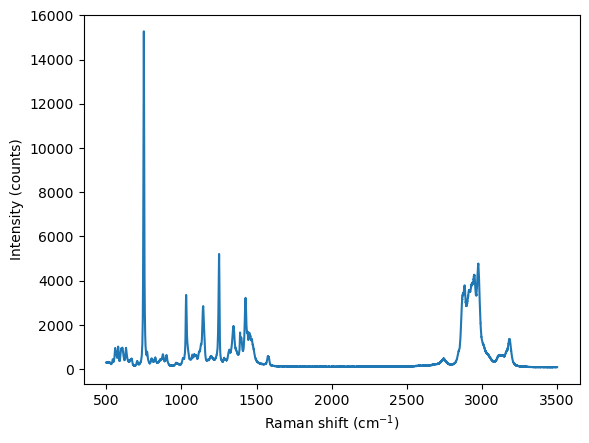

In [2]:
import numpy as np
import matplotlib.pyplot as plt

w, i = np.loadtxt("../../data/raman.txt", usecols=(0, 1), unpack=True)

plt.plot(w, i)
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (counts)");

The next thing to do is narrow our focus to the region we are interested in between 1340 cm<sup>-1</sup> and 1360 cm<sup>-1</sup>.



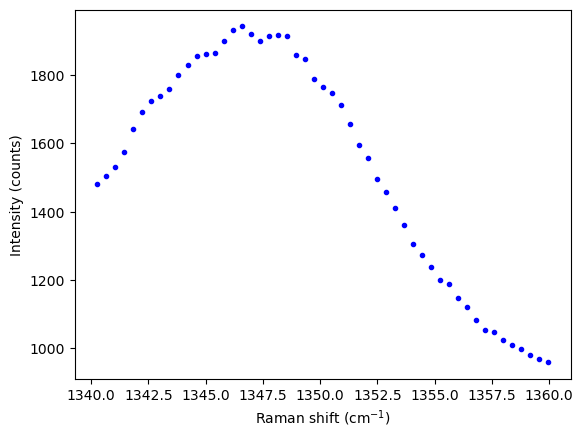

In [3]:
ind = (w > 1340) & (w < 1360)
w1 = w[ind]
i1 = i[ind]

plt.figure()
plt.plot(w1, i1, "b. ")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (counts)");

Next we consider a scipy:UnivariateSpline. This function "smooths" the data.



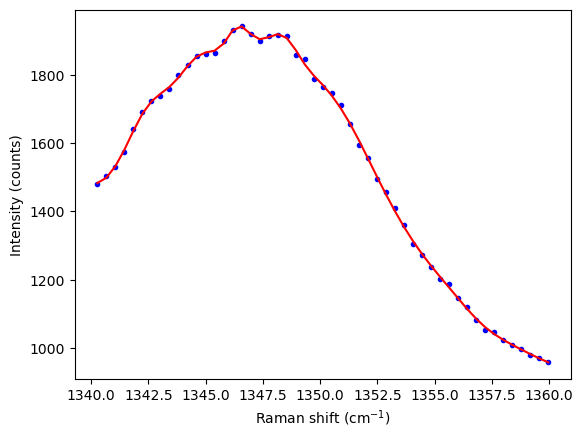

In [4]:
from scipy.interpolate import UnivariateSpline

# s is a "smoothing" factor
sp = UnivariateSpline(w1, i1, k=4, s=2000)

plt.plot(w1, i1, "b. ")
plt.plot(w1, sp(w1), "r-")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (counts)");

Note that the UnivariateSpline function returns a "callable" function! Our next goal is to find the places where there are peaks. This is defined by the first derivative of the data being equal to zero. It is easy to get the first derivative of a UnivariateSpline with a second argument as shown below.



Roots = [1346.4623087  1347.42700893 1348.16689639]


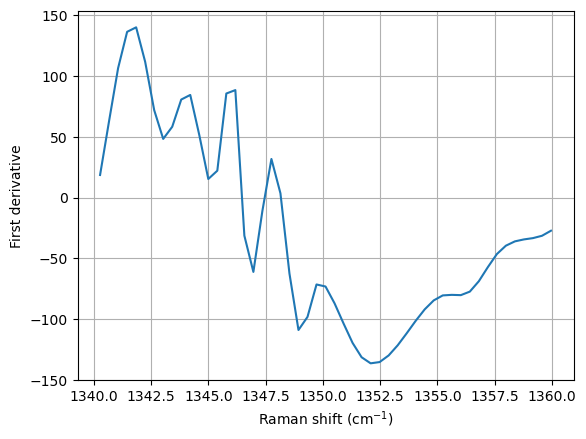

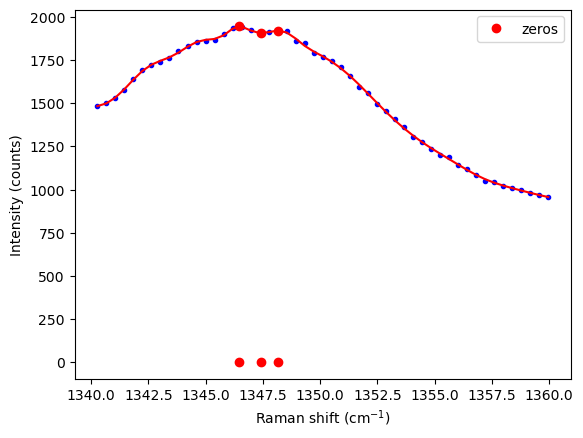

In [5]:
# get the first derivative evaluated at all the points
d1s = sp.derivative()

d1 = d1s(w1)

# we can get the roots directly here, which correspond to minima and
# maxima.
print("Roots = {}".format(sp.derivative().roots()))
minmax = sp.derivative().roots()

plt.clf()
plt.plot(w1, d1, label="first derivative")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("First derivative")
plt.grid()

plt.figure()
plt.plot(minmax, d1s(minmax), "ro ", label="zeros")
plt.legend(loc="best")

plt.plot(w1, i1, "b. ")
plt.plot(w1, sp(w1), "r-")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (counts)")
plt.plot(minmax, sp(minmax), "ro ");

In the end, we have illustrated how to construct a spline smoothing interpolation function and to find maxima in the function, including generating some initial guesses. There is more art to this than you might like, since you have to judge how much smoothing is enough or too much. With too much, you may smooth peaks out. With too little, noise may be mistaken for peaks.



### Summary notes



Using org-mode with  allows a large script to be broken up into mini sections. However, it only seems to work with the default python mode in Emacs, and it does not work with emacs-for-python or the latest python-mode. I also do not really like the output style, e.g. the output from the plotting commands.



## Curve fitting to get overlapping peak areas



Today we examine an approach to fitting curves to overlapping peaks to deconvolute them so we can estimate the area under each curve. We have a text file that contains data from a gas chromatograph with two peaks that overlap. We want the area under each peak to estimate the gas composition. You will see how to read the text file in, parse it to get the data for plotting and analysis, and then how to fit it.

A line like "# of Points	9969" tells us the number of points we have to read. The data starts after a line containing "R.Time	Intensity". Here we read the number of points, and then get the data into arrays.



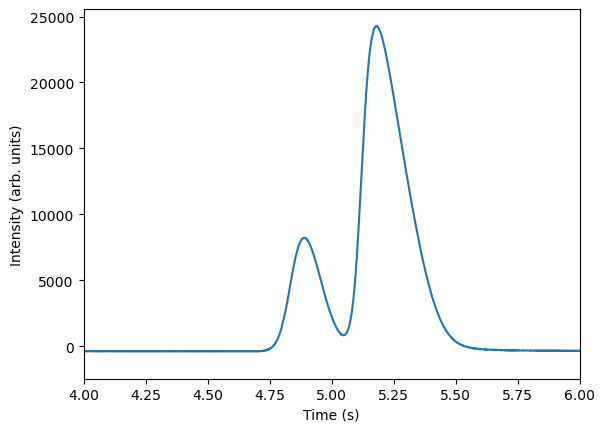

In [8]:
import numpy as np
import matplotlib.pyplot as plt

datafile = "../../data/gc-data-21.txt"

i = 0
with open(datafile) as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if "# of Points" in line:
        npoints = int(line.split()[-1])
    elif "R.Time\tIntensity" in line:
        i += 1
        break

# now get the data
t, intensity = [], []
for j in range(i, i + npoints):
    fields = lines[j].split()
    t += [float(fields[0])]
    intensity += [int(fields[1])]

t = np.array(t)
intensity = np.array(intensity, float)

# now plot the data in the relevant time frame
plt.plot(t, intensity)
plt.xlim([4, 6])
plt.xlabel("Time (s)")
plt.ylabel("Intensity (arb. units)");

You can see there is a non-zero baseline. We will normalize that by the average between 4 and 4.4 seconds.



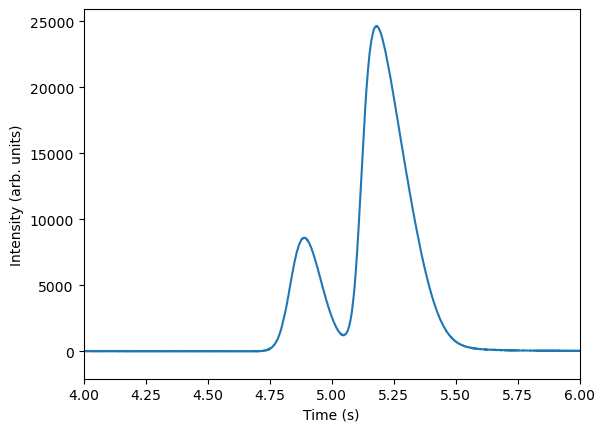

In [9]:
intensity -= np.mean(intensity[(t > 4.0) & (t < 4.4)])
plt.figure()
plt.plot(t, intensity)
plt.xlim([4, 6])
plt.xlabel("Time (s)")
plt.ylabel("Intensity (arb. units)");

The peaks are asymmetric, decaying gaussian functions. We define a function for this



In [10]:
from scipy.special import erf


def asym_peak(t, pars):
    "from Anal. Chem. 1994, 66, 1294-1301"
    a0 = pars[0]  # peak area
    a1 = pars[1]  # elution time
    a2 = pars[2]  # width of gaussian
    a3 = pars[3]  # exponential damping term
    f = (
        a0
        / 2
        / a3
        * np.exp(a2**2 / 2.0 / a3**2 + (a1 - t) / a3)
        * (erf((t - a1) / (np.sqrt(2.0) * a2) - a2 / np.sqrt(2.0) / a3) + 1.0)
    )
    return f

To get two peaks, we simply add two peaks together.



In [11]:
def two_peaks(t, *pars):
    "function of two overlapping peaks"
    a10 = pars[0]  # peak area
    a11 = pars[1]  # elution time
    a12 = pars[2]  # width of gaussian
    a13 = pars[3]  # exponential damping term
    a20 = pars[4]  # peak area
    a21 = pars[5]  # elution time
    a22 = pars[6]  # width of gaussian
    a23 = pars[7]  # exponential damping term
    p1 = asym_peak(t, [a10, a11, a12, a13])
    p2 = asym_peak(t, [a20, a21, a22, a23])
    return p1 + p2

To show the function is close to reasonable, we plot the fitting function with an initial guess for each parameter. The fit is not good, but we have only guessed the parameters for now.



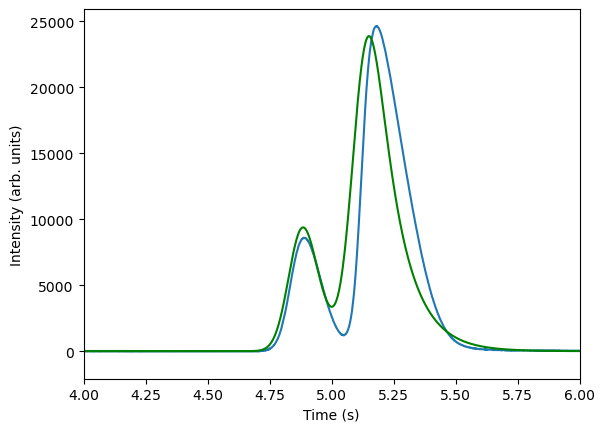

In [12]:
parguess = (1500, 4.85, 0.05, 0.05, 5000, 5.1, 0.05, 0.1)
plt.figure()
plt.plot(t, intensity)
plt.plot(t, two_peaks(t, *parguess), "g-")
plt.xlim([4, 6])
plt.xlabel("Time (s)")
plt.ylabel("Intensity (arb. units)");

Next, we use nonlinear curve fitting from scipy.optimize.curve\_fit



[1.31047745e+03 4.87474058e+00 5.55428411e-02 2.50644959e-02
 5.32571621e+03 5.14121367e+00 4.68231264e-02 1.04110231e-01]


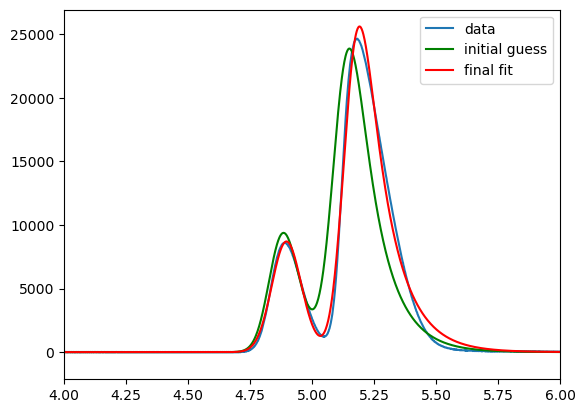

In [13]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(two_peaks, t, intensity, parguess)
print(popt)
plt.plot(t, intensity)
plt.plot(t, two_peaks(t, *parguess), "g-")
plt.xlim([4, 6])
plt.plot(t, two_peaks(t, *popt), "r-")
plt.legend(["data", "initial guess", "final fit"]);

The fits are not perfect. The small peak is pretty good, but there is an unphysical tail on the larger peak, and a small mismatch at the peak. There is not much to do about that, it means the model peak we are using is not a good model for the peak. We will still integrate the areas though.



Area 1 = 1310.48
Area 2 = 5325.72
Area 1 is 19.75% of the whole area
Area 2 is 80.25% of the whole area


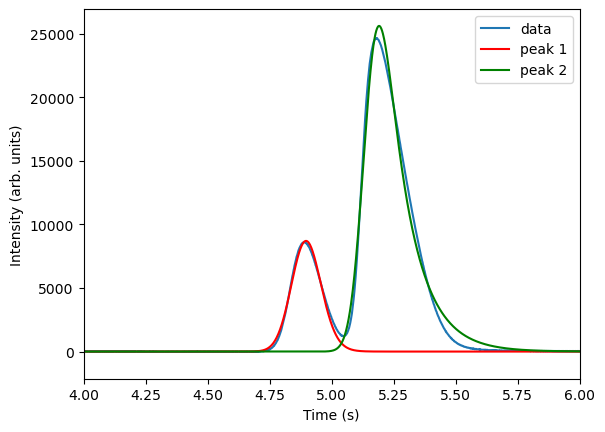

In [14]:
pars1 = popt[0:4]
pars2 = popt[4:8]

peak1 = asym_peak(t, pars1)
peak2 = asym_peak(t, pars2)

area1 = np.trapz(peak1, t)
area2 = np.trapz(peak2, t)

print("Area 1 = {0:1.2f}".format(area1))
print("Area 2 = {0:1.2f}".format(area2))

print("Area 1 is {0:1.2%} of the whole area".format(area1 / (area1 + area2)))
print("Area 2 is {0:1.2%} of the whole area".format(area2 / (area1 + area2)))

plt.figure()
plt.plot(t, intensity)
plt.plot(t, peak1, "r-")
plt.plot(t, peak2, "g-")
plt.xlim([4, 6])
plt.xlabel("Time (s)")
plt.ylabel("Intensity (arb. units)")
plt.legend(["data", "peak 1", "peak 2"]);

This sample was air, and the first peak is oxygen, and the second peak is nitrogen. we come pretty close to the actual composition of air, although it is low on the oxygen content. To do better, one would have to use a calibration curve.

In the end, the overlap of the peaks is pretty small, but it is still difficult to reliably and reproducibly deconvolute them. By using an algorithm like we have demonstrated here, it is possible at least to make the deconvolution reproducible.



### Notable differences from Matlab



1.  The order of arguments to np.trapz is reversed.
2.  The order of arguments to the fitting function scipy.optimize.curve\_fit is different than in Matlab.
3.  The scipy.optimize.curve\_fit function expects a fitting function that has all parameters as arguments, where Matlab expects a vector of parameters.



## Estimating the boiling point of water



[Matlab post](http://matlab.cheme.cmu.edu/2012/01/01/estimating-the-boiling-point-of-water/)

I got distracted looking for Shomate parameters for ethane today, and came across this [website](http://senese.wordpress.com/2010/01/26/notebook-3-2-predicting-boiling-points-from-liquidvapor-gibbs-free-energy-functions/) on predicting the boiling point of water using the Shomate equations. The basic idea is to find the temperature where the Gibbs energy of water as a vapor is equal to the Gibbs energy of the liquid.



In [15]:
import matplotlib.pyplot as plt

Liquid water (http://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Units=SI&Mask=2#Thermo-Condensed)



In [16]:
# valid over 298-500

Hf_liq = -285.830  # kJ/mol
S_liq = 0.06995  # kJ/mol/K
shomateL = [-203.6060, 1523.290, -3196.413, 2474.455, 3.855326, -256.5478, -488.7163, -285.8304]

Gas phase water (http://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Units=SI&Mask=1&Type=JANAFG&Table=on#JANAFG)

Interestingly, these parameters are listed as valid only above 500K. That means we have to extrapolate the values down to 298K. That is risky for polynomial models, as they can deviate substantially outside the region they were fitted to.



In [17]:
Hf_gas = -241.826  # kJ/mol
S_gas = 0.188835  # kJ/mol/K

shomateG = [30.09200, 6.832514, 6.793435, -2.534480, 0.082139, -250.8810, 223.3967, -241.8264]

Now, we wan to compute G for each phase as a function of T



In [18]:
import numpy as np

T = np.linspace(0, 200) + 273.15
t = T / 1000.0

sTT = (
    np.vstack(
        [np.log(t), t, (t**2) / 2.0, (t**3) / 3.0, -1.0 / (2 * t**2), 0 * t, t**0, 0 * t**0]
    ).T
    / 1000.0
)

hTT = np.vstack(
    [t, (t**2) / 2.0, (t**3) / 3.0, (t**4) / 4.0, -1.0 / t, 1 * t**0, 0 * t**0, -1 * t**0]
).T

Gliq = Hf_liq + np.dot(hTT, shomateL) - T * (np.dot(sTT, shomateL))
Ggas = Hf_gas + np.dot(hTT, shomateG) - T * (np.dot(sTT, shomateG))

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

f = interp1d(T, Gliq - Ggas)
(bp,) = fsolve(f, 373)
print("The boiling point is {0} K".format(bp))

The boiling point is 373.20608131187146 K


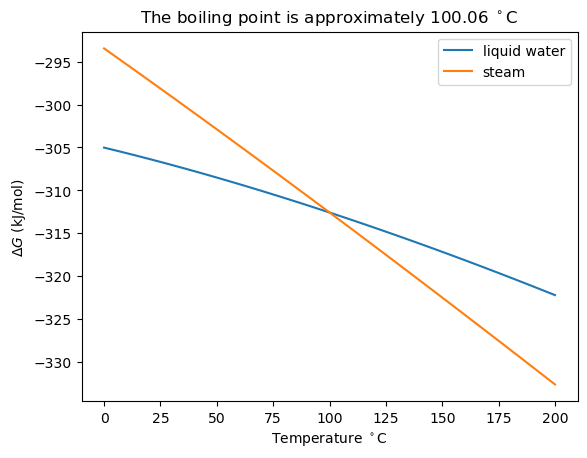

In [19]:
plt.figure()
plt.clf()
plt.plot(T - 273.15, Gliq, T - 273.15, Ggas)
plt.legend(["liquid water", "steam"])

plt.xlabel("Temperature $^\circ$C")
plt.ylabel("$\Delta G$ (kJ/mol)")
plt.title("The boiling point is approximately {0:1.2f} $^\circ$C".format(bp - 273.15));

### Summary



The answer we get us 0.05 K too high, which is not bad considering we estimated it using parameters that were fitted to thermodynamic data and that had finite precision and extrapolated the steam properties below the region the parameters were stated to be valid for.



## Gibbs energy minimization and the NIST webbook



[Matlab post](http://matlab.cheme.cmu.edu/2011/12/25/gibbs-energy-minimization-and-the-nist-webbook/)
In Post 1536 we used the NIST webbook to compute a temperature dependent Gibbs energy of reaction, and then used a reaction extent variable to compute the equilibrium concentrations of each species for the water gas shift reaction.

Today, we look at the direct minimization of the Gibbs free energy of the species, with no assumptions about stoichiometry of reactions. We only apply the constraint of conservation of atoms. We use the NIST Webbook to provide the data for the Gibbs energy of each species.

As a reminder we consider equilibrium between the species $CO$, $H_2O$, $CO_2$ and $H_2$, at 1000K, and 10 atm total pressure with an initial equimolar molar flow rate of $CO$ and $H_2O$.



In [20]:
import numpy as np

T = 1000  # K
R = 8.314e-3  # kJ/mol/K

P = 10.0  # atm, this is the total pressure in the reactor
Po = 1.0  # atm, this is the standard state pressure

We are going to store all the data and calculations in vectors, so we need to assign each position in the vector to a species. Here are the definitions we use in this work.

    1  CO
    2  H2O
    3  CO2
    4  H2



In [21]:
species = ["CO", "H2O", "CO2", "H2"]

# Heats of formation at 298.15 K

Hf298 = [
    -110.53,  # CO
    -241.826,  # H2O
    -393.51,  # CO2
    0.0,
]  # H2

# Shomate parameters for each species
#           A          B           C          D          E            F          G       H
WB = [
    [25.56759, 6.096130, 4.054656, -2.671301, 0.131021, -118.0089, 227.3665, -110.5271],  # CO
    [30.09200, 6.832514, 6.793435, -2.534480, 0.082139, -250.8810, 223.3967, -241.8264],  # H2O
    [24.99735, 55.18696, -33.69137, 7.948387, -0.136638, -403.6075, 228.2431, -393.5224],  # CO2
    [33.066178, -11.363417, 11.432816, -2.772874, -0.158558, -9.980797, 172.707974, 0.0],
]  # H2

WB = np.array(WB)

# Shomate equations
t = T / 1000
T_H = np.array([t, t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0])
T_S = np.array([np.log(t), t, t**2 / 2.0, t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0])

H = np.dot(WB, T_H)  # (H - H_298.15) kJ/mol
S = np.dot(WB, T_S / 1000.0)  # absolute entropy kJ/mol/K

Gjo = Hf298 + H - T * S  # Gibbs energy of each component at 1000 K

Now, construct the Gibbs free energy function, accounting for the change in activity due to concentration changes (ideal mixing).



In [22]:
def func(nj):
    nj = np.array(nj)
    Enj = np.sum(nj)
    Gj = Gjo / (R * T) + np.log(nj / Enj * P / Po)
    return np.dot(nj, Gj)

We impose the constraint that all atoms are conserved from the initial conditions to the equilibrium distribution of species. These constraints are in the form of $A_{eq} n = b_{eq}$, where $n$ is the vector of mole numbers for each species.



In [23]:
Aeq = np.array(
    [
        [1, 0, 1, 0],  # C balance
        [1, 1, 2, 0],  # O balance
        [0, 2, 0, 2],
    ]
)  # H balance

# equimolar feed of 1 mol H2O and 1 mol CO
beq = np.array(
    [
        1,  # mol C fed
        2,  # mol O fed
        2,
    ]
)  # mol H fed


def ec1(nj):
    "conservation of atoms constraint"
    return np.dot(Aeq, nj) - beq

Now we are ready to solve the problem.



In [24]:
from scipy.optimize import fmin_slsqp

n0 = [0.5, 0.5, 0.5, 0.5]  # initial guesses
N = fmin_slsqp(func, n0, f_eqcons=ec1)
print(N)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -91.20483230796889
            Iterations: 2
            Function evaluations: 11
            Gradient evaluations: 2
[0.45502309 0.45502309 0.54497691 0.54497691]


### Compute mole fractions and partial pressures



The pressures here are in good agreement with the pressures found by other methods. The minor disagreement (in the third or fourth decimal place) is likely due to convergence tolerances in the different algorithms used.



In [25]:
yj = N / np.sum(N)
Pj = yj * P

for s, y, p in zip(species, yj, Pj):
    print("{0:10s}: {1:1.2f} {2:1.2f}".format(s, y, p))

CO        : 0.23 2.28
H2O       : 0.23 2.28
CO2       : 0.27 2.72
H2        : 0.27 2.72


### Computing equilibrium constants



We can compute the equilibrium constant for the reaction $CO + H_2O \rightleftharpoons CO_2 + H_2$. Compared to the value of K = 1.44 we found at the end of Post 1536 , the agreement is excellent. Note, that to define an equilibrium constant it is necessary to specify a reaction, even though it is not necessary to even consider a reaction to obtain the equilibrium distribution of species!



In [26]:
nuj = np.array([-1, -1, 1, 1])  # stoichiometric coefficients of the reaction
K = np.prod(yj**nuj)
print(K)

1.4344629441456016


## Finding equilibrium composition by direct minimization of Gibbs free energy on mole numbers



[Matlab post](http://matlab.cheme.cmu.edu/2011/12/25/finding-equilibrium-composition-by-direct-minimization-of-gibbs-free-energy-on-mole-numbers/)
Adapted from problem 4.5 in Cutlip and Shacham
Ethane and steam are fed to a steam cracker at a total pressure of 1 atm and at 1000K at a ratio of 4 mol H2O to 1 mol ethane. Estimate the equilibrium distribution of products (CH4, C2H4, C2H2, CO2, CO, O2, H2, H2O, and C2H6).

Solution method: We will construct a Gibbs energy function for the mixture, and obtain the equilibrium composition by minimization of the function subject to elemental mass balance constraints.



In [27]:
import numpy as np

R = 0.00198588  # kcal/mol/K
T = 1000  # K

species = ["CH4", "C2H4", "C2H2", "CO2", "CO", "O2", "H2", "H2O", "C2H6"]

# $G_^\circ for each species. These are the heats of formation for each
# species.
Gjo = np.array([4.61, 28.249, 40.604, -94.61, -47.942, 0, 0, -46.03, 26.13])  # kcal/mol

### The Gibbs energy of a mixture



We start with $G=\sum\limits_j n_j \mu_j$. Recalling that we define $\mu_j = G_j^\circ + RT \ln a_j$, and in the ideal gas limit, $a_j = y_j P/P^\circ$, and that $y_j = \frac{n_j}{\sum n_j}$. Since in this problem, P = 1 atm, this leads to the function $\frac{G}{RT} = \sum\limits_{j=1}^n n_j\left(\frac{G_j^\circ}{RT} + \ln \frac{n_j}{\sum n_j}\right)$.



In [28]:
import numpy as np


def func(nj):
    nj = np.array(nj)
    Enj = np.sum(nj)
    G = np.sum(nj * (Gjo / R / T + np.log(nj / Enj)))
    return G

### Linear equality constraints for atomic mass conservation



The total number of each type of atom must be the same as what entered the reactor. These form equality constraints on the equilibrium composition. We express these constraints as: $A_{eq} n = b$ where $n$ is a vector of the moles of each species present in the mixture. CH4 C2H4 C2H2 CO2 CO O2 H2 H2O C2H6



In [29]:
Aeq = np.array(
    [
        [0, 0, 0, 2, 1, 2, 0, 1, 0],  # oxygen balance
        [4, 4, 2, 0, 0, 0, 2, 2, 6],  # hydrogen balance
        [1, 2, 2, 1, 1, 0, 0, 0, 2],
    ]
)  # carbon balance

# the incoming feed was 4 mol H2O and 1 mol ethane
beq = np.array(
    [
        4,  # moles of oxygen atoms coming in
        14,  # moles of hydrogen atoms coming in
        2,
    ]
)  # moles of carbon atoms coming in


def ec1(n):
    "equality constraint"
    return np.dot(Aeq, n) - beq


def ic1(n):
    """inequality constraint
    all n>=0
    """
    return n

Now we solve the problem.



In [30]:
# initial guess suggested in the example
n0 = [1e-3, 1e-3, 1e-3, 0.993, 1.0, 1e-4, 5.992, 1.0, 1e-3]

# n0 = [0.066, 8.7e-08, 2.1e-14, 0.545, 1.39, 5.7e-14, 5.346, 1.521, 1.58e-7]

from scipy.optimize import fmin_slsqp

print(func(n0))

X = fmin_slsqp(func, n0, f_eqcons=ec1, f_ieqcons=ic1, iter=900, acc=1e-12)

for s, x in zip(species, X):
    print("{0:10s} {1:1.4g}".format(s, x))

# check that constraints were met
print(np.dot(Aeq, X) - beq)
print(np.all(np.abs(np.dot(Aeq, X) - beq) < 1e-12))

-103.62526515484863
Optimization terminated successfully    (Exit mode 0)
            Current function value: -104.40395152367506
            Iterations: 14
            Function evaluations: 172
            Gradient evaluations: 14
CH4        0.06644
C2H4       8.773e-08
C2H2       4.017e-14
CO2        0.545
CO         1.389
O2         1.081e-13
H2         5.346
H2O        1.521
C2H6       1.632e-07
[ 0.00000000e+00 -1.77635684e-15  4.44089210e-16]
True


/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/1892264215.py:6: RuntimeWarning: invalid value encountered in log
  G = np.sum(nj * (Gjo / R / T + np.log(nj / Enj)))


I found it necessary to tighten the accuracy parameter to get pretty good matches to the solutions found in Matlab. It was also necessary to increase the number of iterations. Even still, not all of the numbers match well, especially the very small numbers. You can, however, see that the constraints were satisfied pretty well.

Interestingly there is a distribution of products! That is interesting because only steam and ethane enter the reactor, but a small fraction of methane is formed! The main product is hydrogen. The stoichiometry of steam reforming is ideally $C_2H_6 + 4H_2O \rightarrow 2CO_2 + 7 H2$. Even though nearly all the ethane is consumed, we do not get the full yield of hydrogen. It appears that another equilibrium, one between CO, CO2, H2O and H2, may be limiting that, since the rest of the hydrogen is largely in the water. It is also of great importance that we have not said anything about reactions, i.e. how these products were formed.

The water gas shift reaction is: $CO + H_2O \rightleftharpoons CO_2 + H_2$. We can compute the Gibbs free energy of the reaction from the heats of formation of each species. Assuming these are the formation energies at 1000K, this is the reaction free energy at 1000K.



In [31]:
G_wgs = Gjo[3] + Gjo[6] - Gjo[4] - Gjo[7]
print(G_wgs)

K = np.exp(-G_wgs / (R * T))
print(K)

-0.6379999999999981
1.3788752810890879


### Equilibrium constant based on mole numbers



One normally uses activities to define the equilibrium constant. Since there are the same number of moles on each side of the reaction all factors that convert mole numbers to activity, concentration or pressure cancel, so we simply consider the ratio of mole numbers here.



In [32]:
print((X[3] * X[6]) / (X[4] * X[7]))

1.3788826772653788


This is very close to the equilibrium constant computed above.

Clearly, there is an equilibrium between these species that prevents the complete reaction of steam reforming.



### Summary



This is an appealing way to minimize the Gibbs energy of a mixture. No assumptions about reactions are necessary, and the constraints are easy to identify. The Gibbs energy function is especially easy to code.



## The Gibbs free energy of a reacting mixture and the equilibrium composition



[Matlab post](http://matlab.cheme.cmu.edu/2011/12/20/the-gibbs-free-energy-of-a-reacting-mixture-and-the-equilibrium-composition/)

In this post we derive the equations needed to find the equilibrium composition of a reacting mixture. We use the method of direct minimization of the Gibbs free energy of the reacting mixture.

The Gibbs free energy of a mixture is defined as $G = \sum\limits_j \mu_j n_j$ where $\mu_j$ is the chemical potential of species $j$, and it is temperature and pressure dependent, and $n_j$ is the number of moles of species $j$.

We define the chemical potential as $\mu_j = G_j^\circ + RT\ln a_j$, where $G_j^\circ$ is the Gibbs energy in a standard state, and $a_j$ is the activity of species $j$ if the pressure and temperature are not at standard state conditions.

If a reaction is occurring, then the number of moles of each species are related to each other through the reaction extent $\epsilon$ and stoichiometric coefficients: $n_j = n_{j0} + \nu_j \epsilon$. Note that the reaction extent has units of moles.

Combining these three equations and expanding the terms leads to:

$$G = \sum\limits_j n_{j0}G_j^\circ +\sum\limits_j \nu_j G_j^\circ \epsilon +RT\sum\limits_j(n_{j0} + \nu_j\epsilon)\ln a_j $$

The first term is simply the initial Gibbs free energy that is present before any reaction begins, and it is a constant. It is difficult to evaluate, so we will move it to the left side of the equation in the next step, because it does not matter what its value is since it is a constant. The second term is related to the Gibbs free energy of reaction: $\Delta_rG = \sum\limits_j \nu_j G_j^\circ$. With these observations we rewrite the equation as:

$$G - \sum\limits_j n_{j0}G_j^\circ = \Delta_rG \epsilon +RT\sum\limits_j(n_{j0} + \nu_j\epsilon)\ln a_j $$

Now, we have an equation that allows us to compute the change in Gibbs free energy as a function of the reaction extent, initial number of moles of each species, and the activities of each species. This difference in Gibbs free energy has no natural scale, and depends on the size of the system, i.e. on $n_{j0}$. It is desirable to avoid this, so we now rescale the equation by the total initial moles present, $n_{T0}$ and define a new variable $\epsilon' = \epsilon/n_{T0}$, which is dimensionless. This leads to:

$$ \frac{G - \sum\limits_j n_{j0}G_j^\circ}{n_{T0}} = \Delta_rG \epsilon' + RT \sum\limits_j(y_{j0} + \nu_j\epsilon')\ln a_j $$

where $y_{j0}$ is the initial mole fraction of species $j$ present. The mole fractions are intensive properties that do not depend on the system size. Finally, we need to address $a_j$. For an ideal gas, we know that $A_j = \frac{y_j P}{P^\circ}$, where the numerator is the partial pressure of species $j$ computed from the mole fraction of species $j$ times the total pressure. To get the mole fraction we note:

$$y_j = \frac{n_j}{n_T} = \frac{n_{j0} + \nu_j \epsilon}{n_{T0} + \epsilon \sum\limits_j \nu_j} = \frac{y_{j0} + \nu_j \epsilon'}{1 + \epsilon'\sum\limits_j \nu_j} $$

This finally leads us to an equation that we can evaluate as a function of reaction extent:

$$ \frac{G - \sum\limits_j n_{j0}G_j^\circ}{n_{T0}} = \widetilde{\widetilde{G}} = \Delta_rG \epsilon' + RT\sum\limits_j(y_{j0} + \nu_j\epsilon') \ln\left(\frac{y_{j0}+\nu_j\epsilon'}{1+\epsilon'\sum\limits_j\nu_j} \frac{P}{P^\circ}\right) $$

we use a double tilde notation to distinguish this quantity from the quantity derived by Rawlings and Ekerdt which is further normalized by a factor of $RT$. This additional scaling makes the quantities dimensionless, and makes the quantity have a magnitude of order unity, but otherwise has no effect on the shape of the graph.

Finally, if we know the initial mole fractions, the initial total pressure, the Gibbs energy of reaction, and the stoichiometric coefficients, we can plot the scaled reacting mixture energy as a function of reaction extent. At equilibrium, this energy will be a minimum. We consider the example in Rawlings and Ekerdt where isobutane (I) reacts with 1-butene (B) to form 2,2,3-trimethylpentane (P). The reaction occurs at a total pressure of 2.5 atm at 400K, with equal molar amounts of I and B. The standard Gibbs free energy of reaction at 400K is -3.72 kcal/mol. Compute the equilibrium composition.



In [33]:
import numpy as np

R = 8.314
P = 250000  # Pa
P0 = 100000  # Pa, approximately 1 atm
T = 400  # K

Grxn = -15564.0  # J/mol
yi0 = 0.5
yb0 = 0.5
yp0 = 0.0  # initial mole fractions

yj0 = np.array([yi0, yb0, yp0])
nu_j = np.array([-1.0, -1.0, 1.0])  # stoichiometric coefficients


def Gwigglewiggle(extentp):
    diffg = Grxn * extentp
    sum_nu_j = np.sum(nu_j)
    for i, y in enumerate(yj0):
        x1 = yj0[i] + nu_j[i] * extentp
        x2 = x1 / (1.0 + extentp * sum_nu_j)
        diffg += R * T * x1 * np.log(x2 * P / P0)
    return diffg

There are bounds on how large $\epsilon'$ can be. Recall that $n_j = n_{j0} + \nu_j \epsilon$, and that $n_j \ge 0$. Thus, $\epsilon_{max} = -n_{j0}/\nu_j$, and the maximum value that $\epsilon'$ can have is therefore $-y_{j0}/\nu_j$ where $y_{j0}>0$. When there are multiple species, you need the smallest $epsilon'_{max}$ to avoid getting negative mole numbers.



/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/2870202885.py:20: RuntimeWarning: divide by zero encountered in log
  diffg += R * T * x1 * np.log(x2 * P / P0)
/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/2870202885.py:20: RuntimeWarning: invalid value encountered in multiply
  diffg += R * T * x1 * np.log(x2 * P / P0)


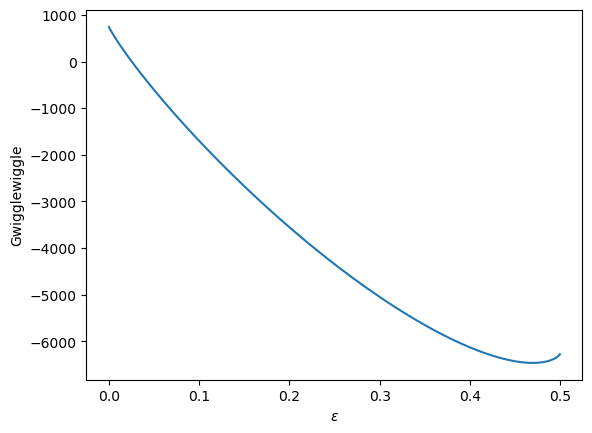

In [34]:
epsilonp_max = min(-yj0[yj0 > 0] / nu_j[yj0 > 0])
epsilonp = np.linspace(1e-6, epsilonp_max, 1000)
import matplotlib.pyplot as plt

plt.plot(epsilonp, Gwigglewiggle(epsilonp))
plt.xlabel("$\epsilon$")
plt.ylabel("Gwigglewiggle");

Now we simply minimize our Gwigglewiggle function. Based on the figure above, the miminum is near 0.45.



0.46959618248998036


/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/2870202885.py:20: RuntimeWarning: divide by zero encountered in log
  diffg += R * T * x1 * np.log(x2 * P / P0)
/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/2870202885.py:20: RuntimeWarning: invalid value encountered in multiply
  diffg += R * T * x1 * np.log(x2 * P / P0)


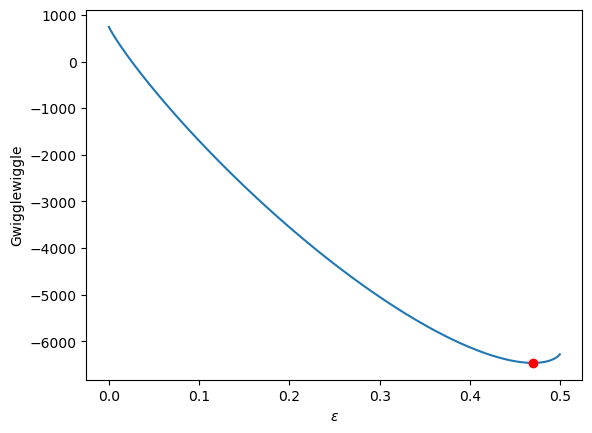

In [35]:
from scipy.optimize import fminbound

epsilonp_eq = fminbound(Gwigglewiggle, 0.4, 0.5)
print(epsilonp_eq)

plt.plot(epsilonp, Gwigglewiggle(epsilonp))
plt.xlabel("$\epsilon$")
plt.ylabel("Gwigglewiggle")
plt.plot([epsilonp_eq], [Gwigglewiggle(epsilonp_eq)], "ro");

To compute equilibrium mole fractions we do this:



In [36]:
yi = (yi0 + nu_j[0] * epsilonp_eq) / (1.0 + epsilonp_eq * np.sum(nu_j))
yb = (yb0 + nu_j[1] * epsilonp_eq) / (1.0 + epsilonp_eq * np.sum(nu_j))
yp = (yp0 + nu_j[2] * epsilonp_eq) / (1.0 + epsilonp_eq * np.sum(nu_j))

print(yi, yb, yp)

# or this
y_j = (yj0 + np.dot(nu_j, epsilonp_eq)) / (1.0 + epsilonp_eq * np.sum(nu_j))
print(y_j)

0.05732201863242677 0.05732201863242677 0.8853559627351465
[0.05732202 0.05732202 0.88535596]


$K = \frac{a_P}{a_I a_B} = \frac{y_p P/P^\circ}{y_i P/P^\circ y_b P/P^\circ} = \frac{y_P}{y_i y_b}\frac{P^\circ}{P}$.

We can express the equilibrium constant like this :$K = \prod\limits_j a_j^{\nu_j}$, and compute it with a single line of code.



In [37]:
K = np.exp(-Grxn / R / T)
print("K from delta G ", K)
print("K as ratio of mole fractions ", yp / (yi * yb) * P0 / P)
print("compact notation: ", np.prod((y_j * P / P0) ** nu_j))

K from delta G  107.77629474221368
K as ratio of mole fractions  107.77920006547463
compact notation:  107.77920006547463


These results are very close, and only disagree because of the default tolerance used in identifying the minimum of our function. You could tighten the tolerances by setting options to the fminbnd function.



### Summary



In this post we derived an equation for the Gibbs free energy of a reacting mixture and used it to find the equilibrium composition. In future posts we will examine some alternate forms of the equations that may be more useful in some circumstances.



## Water gas shift equilibria via the NIST Webbook



[Matlab post](http://matlab.cheme.cmu.edu/2011/12/12/water-gas-shift-equilibria-via-the-nist-webbook/)

The [NIST webbook](http://webbook.nist.gov/chemistry/) provides parameterized models of the enthalpy, entropy and heat capacity of many molecules. In this example, we will examine how to use these to compute the equilibrium constant for the water gas shift reaction $CO + H_2O \rightleftharpoons CO_2 + H_2$ in the temperature range of 500K to 1000K.

Parameters are provided for:

Cp = heat capacity (J/mol\*K)
H = standard enthalpy (kJ/mol)
S = standard entropy (J/mol\*K)

with models in the form: $Cp^\circ = A + B*t + C*t^2 + D*t^3 + E/t^2$

$H^\circ - H^\circ_{298.15}= A*t + B*t^2/2 + C*t^3/3 + D*t^4/4 - E/t + F - H$

$S^\circ = A*ln(t) + B*t + C*t^2/2 + D*t^3/3 - E/(2*t^2) + G$

where $t=T/1000$, and $T$ is the temperature in Kelvin. We can use this data to calculate equilibrium constants in the following manner. First, we have heats of formation at standard state for each compound; for elements, these are zero by definition, and for non-elements, they have values available from the NIST webbook. There are also values for the absolute entropy at standard state. Then, we have an expression for the change in enthalpy from standard state as defined above, as well as the absolute entropy. From these we can derive the reaction enthalpy, free energy and entropy at standard state, as well as at other temperatures.

We will examine the water gas shift enthalpy, free energy and equilibrium constant from 500K to 1000K, and finally compute the equilibrium composition of a gas feed containing 5 atm of CO and H\_2 at 1000K.



In [38]:
import numpy as np

T = np.linspace(500, 1000)  # degrees K
t = T / 1000;

### hydrogen



http://webbook.nist.gov/cgi/cbook.cgi?ID=C1333740&Units=SI&Mask=1#Thermo-Gas



In [39]:
# T = 298-1000K valid temperature range
A = 33.066178
B = -11.363417
C = 11.432816
D = -2.772874
E = -0.158558
F = -9.980797
G = 172.707974
H = 0.0

Hf_29815_H2 = 0.0  # kJ/mol
S_29815_H2 = 130.68  # J/mol/K

dH_H2 = A * t + B * t**2 / 2 + C * t**3 / 3 + D * t**4 / 4 - E / t + F - H
S_H2 = A * np.log(t) + B * t + C * t**2 / 2 + D * t**3 / 3 - E / (2 * t**2) + G;

### H<sub>2</sub>O



http://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Units=SI&Mask=1#Thermo-Gas

Note these parameters limit the temperature range we can examine, as these parameters are not valid below 500K. There is another set of parameters for lower temperatures, but we do not consider them here.



In [40]:
# 500-1700 K valid temperature range
A = 30.09200
B = 6.832514
C = 6.793435
D = -2.534480
E = 0.082139
F = -250.8810
G = 223.3967
H = -241.8264

Hf_29815_H2O = -241.83  # this is Hf.
S_29815_H2O = 188.84

dH_H2O = A * t + B * t**2 / 2 + C * t**3 / 3 + D * t**4 / 4 - E / t + F - H
S_H2O = A * np.log(t) + B * t + C * t**2 / 2 + D * t**3 / 3 - E / (2 * t**2) + G;

### CO



http://webbook.nist.gov/cgi/cbook.cgi?ID=C630080&Units=SI&Mask=1#Thermo-Gas



In [41]:
# 298. - 1300K valid temperature range
A = 25.56759
B = 6.096130
C = 4.054656
D = -2.671301
E = 0.131021
F = -118.0089
G = 227.3665
H = -110.5271

Hf_29815_CO = -110.53  # this is Hf kJ/mol.
S_29815_CO = 197.66

dH_CO = A * t + B * t**2 / 2 + C * t**3 / 3 + D * t**4 / 4 - E / t + F - H
S_CO = A * np.log(t) + B * t + C * t**2 / 2 + D * t**3 / 3 - E / (2 * t**2) + G;

### CO<sub>2</sub>



http://webbook.nist.gov/cgi/cbook.cgi?ID=C124389&Units=SI&Mask=1#Thermo-Gas



In [42]:
# 298. - 1200.K valid temperature range
A = 24.99735
B = 55.18696
C = -33.69137
D = 7.948387
E = -0.136638
F = -403.6075
G = 228.2431
H = -393.5224

Hf_29815_CO2 = -393.51  # this is Hf.
S_29815_CO2 = 213.79

dH_CO2 = A * t + B * t**2 / 2 + C * t**3 / 3 + D * t**4 / 4 - E / t + F - H
S_CO2 = A * np.log(t) + B * t + C * t**2 / 2 + D * t**3 / 3 - E / (2 * t**2) + G;

### Standard state heat of reaction



We compute the enthalpy and free energy of reaction at 298.15 K for the following reaction $CO + H2O \rightleftharpoons H2 + CO2$.



In [43]:
Hrxn_29815 = Hf_29815_CO2 + Hf_29815_H2 - Hf_29815_CO - Hf_29815_H2O
Srxn_29815 = S_29815_CO2 + S_29815_H2 - S_29815_CO - S_29815_H2O
Grxn_29815 = Hrxn_29815 - 298.15 * (Srxn_29815) / 1000
print("deltaH = {0:1.2f}".format(Hrxn_29815))
print("deltaG = {0:1.2f}".format(Grxn_29815))

deltaH = -41.15
deltaG = -28.62


### Non-standard state $\Delta H$ and $\Delta G$



We have to correct for temperature change away from standard state. We only correct the enthalpy for this temperature change. The correction looks like this:

$$ \Delta H_{rxn}(T) = \Delta H_{rxn}(T_{ref}) + \sum_i \nu_i (H_i(T)-H_i(T_{ref}))$$

Where $\nu_i$ are the stoichiometric coefficients of each species, with appropriate sign for reactants and products, and $(H_i(T)-H_i(T_{ref})$ is precisely what is calculated for each species with the equations

The entropy is on an absolute scale, so we directly calculate entropy at each temperature. Recall that H is in kJ/mol and S is in J/mol/K, so we divide S by 1000 to make the units match.



In [44]:
Hrxn = Hrxn_29815 + dH_CO2 + dH_H2 - dH_CO - dH_H2O
Grxn = Hrxn - T * (S_CO2 + S_H2 - S_CO - S_H2O) / 1000

### Plot how the $\Delta G$ varies with temperature



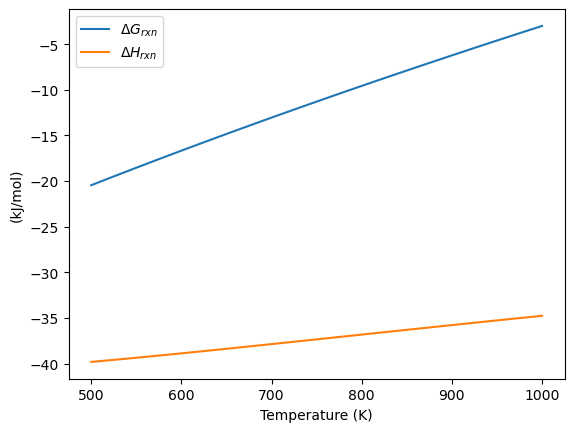

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.clf()
plt.plot(T, Grxn, label="$\Delta G_{rxn}$")
plt.plot(T, Hrxn, label="$\Delta H_{rxn}$")
plt.xlabel("Temperature (K)")
plt.ylabel("(kJ/mol)")
plt.legend(loc="best");

Over this temperature range the reaction is exothermic, although near 1000K it is just barely exothermic. At higher temperatures we expect the reaction to become endothermic.



### Equilibrium constant calculation



Note the equilibrium constant starts out high, i.e. strongly favoring the formation of products, but drops very quicky with increasing temperature.



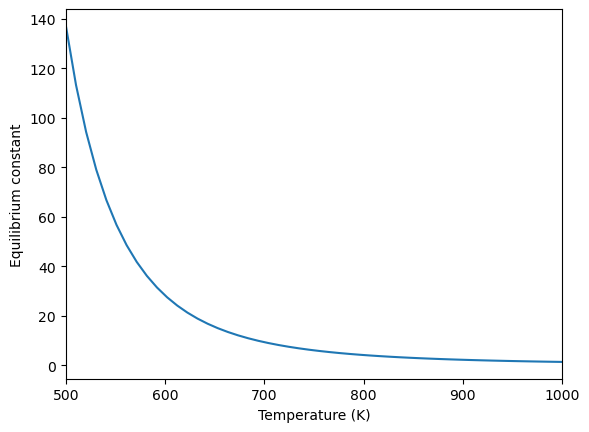

In [47]:
R = 8.314e-3  # kJ/mol/K
K = np.exp(-Grxn / R / T)
plt.figure()
plt.plot(T, K)
plt.xlim([500, 1000])
plt.xlabel("Temperature (K)")
plt.ylabel("Equilibrium constant");

### Equilibrium yield of WGS



Now let us suppose we have a reactor with a feed of H\_2O and CO at 10atm at 1000K. What is the equilibrium yield of H\_2? Let $\epsilon$ be the extent of reaction, so that $F_i = F_{i,0} + \nu_i \epsilon$. For reactants, $\nu_i$ is negative, and for products, $\nu_i$ is positive. We have to solve for the extent of reaction that satisfies the equilibrium condition.



In [48]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

#
# A = CO
# B = H2O
# C = H2
# D = CO2

Pa0 = 5
Pb0 = 5
Pc0 = 0
Pd0 = 0  # pressure in atm
R = 0.082
Temperature = 1000
# we can estimate the equilibrium like this. We could also calculate it
# using the equations above, but we would have to evaluate each term. Above
# we simply computed a vector of enthalpies, entropies, etc... Here we interpolate
K_func = interp1d(T, K)
K_Temperature = K_func(1000)


# If we let X be fractional conversion then we have $C_A = C_{A0}(1-X)$,
# $C_B = C_{B0}-C_{A0}X$, $C_C = C_{C0}+C_{A0}X$, and $C_D =
# C_{D0}+C_{A0}X$. We also have $K(T) = (C_C C_D)/(C_A C_B)$, which finally
# reduces to $0 = K(T) - Xeq^2/(1-Xeq)^2$ under these conditions.


def f(X):
    return K_Temperature - X**2 / (1 - X) ** 2


x0 = 0.5
(Xeq,) = fsolve(f, x0)

print("The equilibrium conversion for these feed conditions is: {0:1.2f}".format(Xeq))

The equilibrium conversion for these feed conditions is: 0.55


### Compute gas phase pressures of each species



Since there is no change in moles for this reaction, we can directly calculation the pressures from the equilibrium conversion and the initial pressure of gases. you can see there is a slightly higher pressure of H\_2 and CO\_2 than the reactants, consistent with the equilibrium constant of about 1.44 at 1000K. At a lower temperature there would be a much higher yield of the products. For example, at 550K the equilibrium constant is about 58, and the pressure of H\_2 is 4.4 atm due to a much higher equilibrium conversion of 0.88.



In [49]:
P_CO = Pa0 * (1 - Xeq)
P_H2O = Pa0 * (1 - Xeq)
P_H2 = Pa0 * Xeq
P_CO2 = Pa0 * Xeq

print(P_CO, P_H2O, P_H2, P_CO2)

2.2747854427996614 2.2747854427996614 2.7252145572003386 2.7252145572003386


### Compare the equilibrium constants



We can compare the equilibrium constant from the Gibbs free energy and the one from the ratio of pressures. They should be the same!



In [50]:
print(K_Temperature)
print((P_CO2 * P_H2) / (P_CO * P_H2O))

1.4352267476228722
1.4352267476228684


They are the same.



### Summary



The NIST Webbook provides a plethora of data for computing thermodynamic properties. It is a little tedious to enter it all into Matlab, and a little tricky to use the data to estimate temperature dependent reaction energies. A limitation of the Webbook is that it does not tell you have the thermodynamic properties change with pressure. Luckily, those changes tend to be small.

I noticed a different behavior in interpolation between scipy.interpolate.interp1d and Matlab's interp1. The scipy function returns an interpolating function, whereas the Matlab function directly interpolates new values, and returns the actual interpolated data.



## Constrained minimization to find equilibrium compositions



Adapated from Chemical Reactor analysis and design fundamentals, Rawlings and Ekerdt, appendix A.2.3.

[Matlab post](http://matlab.cheme.cmu.edu/2011/08/12/constrained-minimization-to-find-equilibrium-compositions/)

The equilibrium composition of a reaction is the one that minimizes the total Gibbs free energy. The Gibbs free energy of a reacting ideal gas mixture depends on the mole fractions of each species, which are determined by the initial mole fractions of each species, the extent of reactions that convert each species, and the equilibrium constants.

Reaction 1: $I + B \rightleftharpoons P1$

Reaction 2: $I + B \rightleftharpoons P2$

Here we define the Gibbs free energy of the mixture as a function of the reaction extents.



In [51]:
import numpy as np


def gibbs(E):
    "function defining Gibbs free energy as a function of reaction extents"
    e1 = E[0]
    e2 = E[1]
    # known equilibrium constants and initial amounts
    K1 = 108
    K2 = 284
    P = 2.5
    yI0 = 0.5
    yB0 = 0.5
    yP10 = 0.0
    yP20 = 0.0
    # compute mole fractions
    d = 1 - e1 - e2
    yI = (yI0 - e1 - e2) / d
    yB = (yB0 - e1 - e2) / d
    yP1 = (yP10 + e1) / d
    yP2 = (yP20 + e2) / d
    G = (
        -(e1 * np.log(K1) + e2 * np.log(K2))
        + d * np.log(P)
        + yI * d * np.log(yI)
        + yB * d * np.log(yB)
        + yP1 * d * np.log(yP1)
        + yP2 * d * np.log(yP2)
    )
    return G

The equilibrium constants for these reactions are known, and we seek to find the equilibrium reaction extents so we can determine equilibrium compositions. The equilibrium reaction extents are those that minimize the Gibbs free energy.  We have the following constraints, written in standard less than or equal to form:

$-\epsilon_1 \le 0$

$-\epsilon_2 \le 0$

$\epsilon_1 + \epsilon_2 \le 0.5$

In Matlab we express this in matrix form as Ax=b where

\begin{equation}
A = \left[ \begin{array}{cc} -1 & 0 \\ 0 & -1 \\ 1 & 1 \end{array} \right]
\end{equation}

and

\begin{equation}
b = \left[ \begin{array}{c} 0 \\ 0 \\ 0.5\end{array} \right]
\end{equation}

Unlike in Matlab, in python we construct the inequality constraints as functions that are greater than or equal to zero when the constraint is met.



In [52]:
def constraint1(E):
    e1 = E[0]
    return e1


def constraint2(E):
    e2 = E[1]
    return e2


def constraint3(E):
    e1 = E[0]
    e2 = E[1]
    return 0.5 - (e1 + e2)

Now, we minimize.



In [53]:
from scipy.optimize import fmin_slsqp

X0 = [0.2, 0.2]
X = fmin_slsqp(
    gibbs,
    X0,
    ieqcons=[constraint1, constraint2, constraint3],
    bounds=((0.001, 0.499), (0.001, 0.499)),
)
print(X)

print(gibbs(X))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.5594238377522345
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
[0.13343719 0.35056497]
-2.5594238377522345


/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/1928982228.py:17: RuntimeWarning: invalid value encountered in log
  d * np.log(P) + yI * d * np.log(yI) +
/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/1928982228.py:18: RuntimeWarning: invalid value encountered in log
  yB * d * np.log(yB) + yP1 * d * np.log(yP1) + yP2 * d * np.log(yP2))


One way we can verify our solution is to plot the gibbs function and see where the minimum is, and whether there is more than one minimum. We start by making grids over the range of 0 to 0.5. Note we actually start slightly above zero because at zero there are some numerical imaginary elements of the gibbs function or it is numerically not defined since there are logs of zero there. We also set all elements where the sum of the two extents is greater than 0.5 to near zero, since those regions violate the constraints.



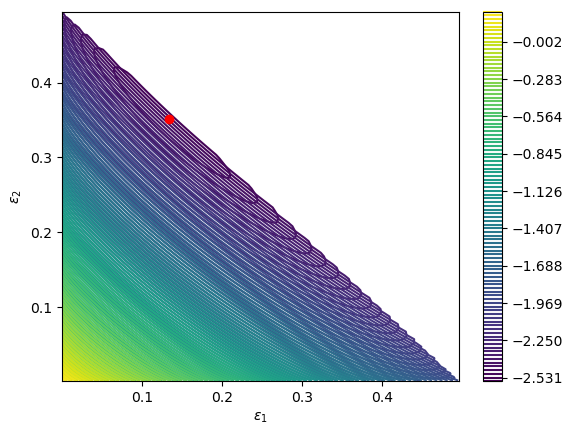

In [54]:
import numpy as np
import matplotlib.pyplot as plt


def gibbs(E):
    "function defining Gibbs free energy as a function of reaction extents"
    e1 = E[0]
    e2 = E[1]
    # known equilibrium constants and initial amounts
    K1 = 108
    K2 = 284
    P = 2.5
    yI0 = 0.5
    yB0 = 0.5
    yP10 = 0.0
    yP20 = 0.0
    # compute mole fractions
    d = 1 - e1 - e2
    yI = (yI0 - e1 - e2) / d
    yB = (yB0 - e1 - e2) / d
    yP1 = (yP10 + e1) / d
    yP2 = (yP20 + e2) / d
    G = (
        -(e1 * np.log(K1) + e2 * np.log(K2))
        + d * np.log(P)
        + yI * d * np.log(yI)
        + yB * d * np.log(yB)
        + yP1 * d * np.log(yP1)
        + yP2 * d * np.log(yP2)
    )
    return G


a = np.linspace(0.001, 0.5, 100)
E1, E2 = np.meshgrid(a, a)

sumE = E1 + E2
E1[sumE >= 0.5] = 0.00001
E2[sumE >= 0.5] = 0.00001

# now evaluate gibbs
G = np.zeros(E1.shape)
m, n = E1.shape

G = gibbs([E1, E2])

CS = plt.contour(E1, E2, G, levels=np.linspace(G.min(), G.max(), 100))
plt.xlabel("$\epsilon_1$")
plt.ylabel("$\epsilon_2$")
plt.colorbar()

plt.plot([0.13336503], [0.35066486], "ro");

You can see we found the minimum. We can compute the mole fractions pretty easily.



In [55]:
e1 = X[0]
e2 = X[1]
yI0 = 0.5
yB0 = 0.5
yP10 = 0
yP20 = 0  # initial mole fractions

d = 1 - e1 - e2
yI = (yI0 - e1 - e2) / d
yB = (yB0 - e1 - e2) / d
yP1 = (yP10 + e1) / d
yP2 = (yP20 + e2) / d

print("y_I = {0:1.3f} y_B = {1:1.3f} y_P1 = {2:1.3f} y_P2 = {3:1.3f}".format(yI, yB, yP1, yP2))

y_I = 0.031 y_B = 0.031 y_P1 = 0.259 y_P2 = 0.679


### summary



I found setting up the constraints in this example to be more confusing than the Matlab syntax.



## Using constrained optimization to find the amount of each phase present



The problem we solve here is that we have several compounds containing Ni and Al, and a bulk mixture of a particular composition of Ni and Al. We want to know which mixture of phases will minimize the total energy. The tricky part is that the optimization is constrained because the mixture of phases must have the overall stoichiometry we want.  We formulate the problem like this.

Basically, we want to minimize the function $E = \sum w_i E_i$, where $w_i$ is the mass of phase $i$, and $E_i$ is the energy per unit mass of phase $i$. There are some constraints to ensure conservation of mass. Let us consider the following compounds: Al, NiAl, Ni3Al, and Ni, and consider a case where the bulk composition of our alloy is 93.8% Ni and balance Al. We want to know which phases are present, and in what proportions. There are some subtleties in considering the formula and molecular weight of an alloy. We consider the formula with each species amount normalized so the fractions all add up to one. For example, Ni\_3Al is represented as Ni<sub>0.75</sub>Al<sub>0.25</sub>, and the molecular weight is computed as 0.75\*MW<sub>Ni</sub> + 0.25\*MW<sub>Al</sub>.

We use scipy.optimize.fmin\_slsqp to solve this problem, and define two equality constraint functions, and the bounds on each weight fraction.

Note: the energies in this example were computed by density functional theory at 0K.



In [56]:
import numpy as np
from scipy.optimize import fmin_slsqp

# these are atomic masses of each species
Ni = 58.693
Al = 26.982

COMPOSITIONS = ["Al", "NiAl", "Ni3Al", "Ni"]
MW = np.array([Al, (Ni + Al) / 2.0, (3 * Ni + Al) / 4.0, Ni])

xNi = np.array([0.0, 0.5, 0.75, 1.0])  # mole fraction of nickel in each compd
WNi = xNi * Ni / MW  # weight fraction of Ni in each cmpd

ENERGIES = np.array([0.0, -0.7, -0.5, 0.0])

BNi = 0.938


def G(w):
    "function to minimize. w is a vector of weight fractions, ENERGIES is defined above."
    return np.dot(w, ENERGIES)


def ec1(w):
    "conservation of Ni constraint"
    return BNi - np.dot(w, WNi)


def ec2(w):
    "weight fractions sum to one constraint"
    return 1 - np.sum(w)


w0 = np.array([0.0, 0.0, 0.5, 0.5])  # guess weight fractions

y = fmin_slsqp(G, w0, eqcons=[ec1, ec2], bounds=[(0, 1)] * len(w0))

for ci, wi in zip(COMPOSITIONS, y):
    print("{0:8s} {1:+8.2%}".format(ci, wi))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.23329964437327755
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2
Al         +0.00%
NiAl       +0.00%
Ni3Al     +46.66%
Ni        +53.34%


So, the sample will be about 47% *by weight* of Ni3Al, and 53% *by weight* of pure Ni.

It may be convenient to formulate this in terms of moles.



In [57]:
import numpy as np
from scipy.optimize import fmin_slsqp

COMPOSITIONS = ["Al", "NiAl", "Ni3Al", "Ni"]
xNi = np.array([0.0, 0.5, 0.75, 1.0])  # define this in mole fractions

ENERGIES = np.array([0.0, -0.7, -0.5, 0.0])

xNiB = 0.875  # bulk Ni composition


def G(n):
    "function to minimize"
    return np.dot(n, ENERGIES)


def ec1(n):
    "conservation of Ni"
    Ntot = np.sum(n)
    return (Ntot * xNiB) - np.dot(n, xNi)


def ec2(n):
    "mole fractions sum to one"
    return 1 - np.sum(n)


n0 = np.array([0.0, 0.0, 0.45, 0.55])  # initial guess of mole fractions

y = fmin_slsqp(G, n0, eqcons=[ec1, ec2], bounds=[(0, 1)] * (len(n0)))

for ci, xi in zip(COMPOSITIONS, y):
    print("{0:8s} {1:+8.2%}".format(ci, xi))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2500000000000001
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2
Al         +0.00%
NiAl       +0.00%
Ni3Al     +50.00%
Ni        +50.00%


This means we have a 1:1 molar ratio of Ni and Ni<sub>0.75</sub>Al<sub>0.25</sub>. That works out to the overall bulk composition in this particular problem.

Let us verify that these two approaches really lead to the same conclusions. On a weight basis we estimate 53.3%wt Ni and 46.7%wt Ni3Al, whereas we predict an equimolar mixture of the two phases. Below we compute the mole fraction of Ni in each case.



In [58]:
# these are atomic masses of each species
Ni = 58.693
Al = 26.982

# Molar case
# 1 mol Ni + 1 mol Ni_{0.75}Al_{0.25}
N1 = 1.0
N2 = 1.0
mol_Ni = 1.0 * N1 + 0.75 * N2
xNi = mol_Ni / (N1 + N2)
print(xNi)

# Mass case
M1 = 0.533
M2 = 0.467
MW1 = Ni
MW2 = 0.75 * Ni + 0.25 * Al

xNi2 = (1.0 * M1 / MW1 + 0.75 * M2 / MW2) / (M1 / MW1 + M2 / MW2)
print(xNi2)

0.875
0.874192746384855


You can see the overall mole fraction of Ni is practically the same in each case.



## Conservation of mass in chemical reactions



[Matlab post](http://matlab.cheme.cmu.edu/2011/12/18/conservation-of-mass-in-chemical-reactions/)

Atoms cannot be destroyed in non-nuclear chemical reactions, hence it follows that the same number of atoms entering a reactor must also leave the reactor. The atoms may leave the reactor in a different molecular configuration due to the reaction, but the total mass leaving the reactor must be the same. Here we look at a few ways to show this.

We consider the water gas shift reaction : $CO + H_2O \rightleftharpoons H_2 + CO_2$. We can illustrate the conservation of mass with the following equation: $\bf{\nu}\bf{M}=\bf{0}$. Where $\bf{\nu}$ is the stoichiometric coefficient vector and $\bf{M}$ is a column vector of molecular weights. For simplicity, we use pure isotope molecular weights, and not the isotope-weighted molecular weights. This equation simply examines the mass on the right side of the equation and the mass on left side of the equation.



In [59]:
import numpy as np

nu = [-1, -1, 1, 1]
M = [28, 18, 2, 44]
print(np.dot(nu, M))

0


You can see that sum of the stoichiometric coefficients times molecular weights is zero. In other words a CO and H\_2O have the same mass as H\_2 and CO\_2.

For any balanced chemical equation, there are the same number of each kind of atom on each side of the equation. Since the mass of each atom is unchanged with reaction, that means the mass of all the species that are reactants must equal the mass of all the species that are products! Here we look at the number of C, O, and H on each side of the reaction. Now if we add the mass of atoms in the reactants and products, it should sum to zero (since we used the negative sign for stoichiometric coefficients of reactants).



In [60]:
import numpy as np

# C   O   H
reactants = [-1, -2, -2]
products = [1, 2, 2]

atomic_masses = [12.011, 15.999, 1.0079]  # atomic masses

print(np.dot(reactants, atomic_masses) + np.dot(products, atomic_masses))

0.0


That is all there is to mass conservation with reactions. Nothing changes if there are lots of reactions, as long as each reaction is properly balanced, and none of them are nuclear reactions!



## Numerically calculating an effectiveness factor for a porous catalyst bead



[Matlab post](http://matlab.cheme.cmu.edu/2011/11/18/numerically-calculating-an-effectiveness-factor-for-a-porous-catalyst-bead/)

If reaction rates are fast compared to diffusion in a porous catalyst pellet, then the observed kinetics will appear to be slower than they really are because not all of the catalyst surface area will be effectively used. For example, the reactants may all be consumed in the near surface area of a catalyst bead, and the inside of the bead will be unutilized because no reactants can get in due to the high reaction rates.

References: Ch 12. Elements of Chemical Reaction Engineering, Fogler, 4th edition.

A mole balance on the particle volume in spherical coordinates with a first order reaction leads to: $\frac{d^2Ca}{dr^2} + \frac{2}{r}\frac{dCa}{dr}-\frac{k}{D_e}C_A=0$ with boundary conditions $C_A(R) = C_{As}$ and $\frac{dCa}{dr}=0$ at $r=0$. We convert this equation to a system of first order ODEs by letting $W_A=\frac{dCa}{dr}$. Then, our two equations become:

$\frac{dCa}{dr} = W_A$

and

$\frac{dW_A}{dr} = -\frac{2}{r} W_A + \frac{k}{D_E} C_A$

We have a condition of no flux ($W_A=0$) at r=0 and Ca(R) = CAs, which makes this a boundary value problem. We use the shooting method here, and guess what Ca(0) is and iterate the guess to get Ca(R) = CAs.

The value of the second differential equation at r=0 is tricky because at this place we have a 0/0 term. We use L'Hopital's rule to evaluate it. The derivative of the top is $\frac{dW_A}{dr}$ and the derivative of the bottom is 1. So, we have
$\frac{dW_A}{dr} = -2\frac{dW_A}{dr} + \frac{k}{D_E} C_A$

Which leads to:

$3 \frac{dW_A}{dr} =  \frac{k}{D_E} C_A$

or $\frac{dW_A}{dr} =  \frac{3k}{D_E} C_A$ at $r=0$.

Finally, we implement the equations in Python and solve.



At r=0.5 Ca=0.20000148865173356
0.5630113483142608
0.5630033628012618


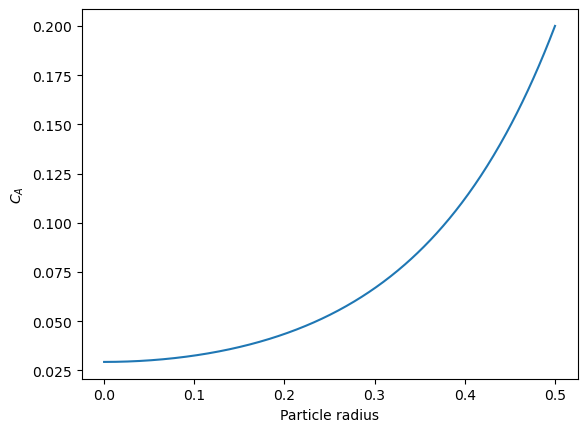

In [61]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

De = 0.1  # diffusivity cm^2/s
R = 0.5  # particle radius, cm
k = 6.4  # rate constant (1/s)
CAs = 0.2  # concentration of A at outer radius of particle (mol/L)


def ode(Y, r):
    Wa = Y[0]  # molar rate of delivery of A to surface of particle
    Ca = Y[1]  # concentration of A in the particle at r
    # this solves the singularity at r = 0
    if r == 0:
        dWadr = k / 3.0 * De * Ca
    else:
        dWadr = -2 * Wa / r + k / De * Ca
    dCadr = Wa
    return [dWadr, dCadr]


# Initial conditions
Ca0 = 0.029315  # Ca(0) (mol/L) guessed to satisfy Ca(R) = CAs
Wa0 = 0  # no flux at r=0 (mol/m^2/s)

rspan = np.linspace(0, R, 500)

Y = odeint(ode, [Wa0, Ca0], rspan)

Ca = Y[:, 1]

# here we check that Ca(R) = Cas
print("At r={0} Ca={1}".format(rspan[-1], Ca[-1]))

plt.plot(rspan, Ca)
plt.xlabel("Particle radius")
plt.ylabel("$C_A$")

r = rspan
eta_numerical = np.trapz(k * Ca * 4 * np.pi * (r**2), r) / np.trapz(k * CAs * 4 * np.pi * (r**2), r)

print(eta_numerical)

phi = R * np.sqrt(k / De)
eta_analytical = (3 / phi**2) * (phi * (1.0 / np.tanh(phi)) - 1)
print(eta_analytical)

You can see the concentration of A inside the particle is significantly lower than outside the particle. That is because it is reacting away faster than it can diffuse into the particle. Hence, the overall reaction rate in the particle is lower than it would be without the diffusion limit.

The effectiveness factor is the ratio of the actual reaction rate in the particle with diffusion limitation to the ideal rate in the particle if there was no concentration gradient:

$$\eta = \frac{\int_0^R k'' a C_A(r) 4 \pi r^2 dr}{\int_0^R k'' a C_{As} 4 \pi r^2 dr}$$

We will evaluate this numerically from our solution and compare it to the analytical solution. The results are in good agreement, and you can make the numerical estimate better by increasing the number of points in the solution so that the numerical integration is more accurate.

Why go through the numerical solution when an analytical solution exists? The analytical solution here is only good for 1st order kinetics in a sphere. What would you do for a complicated rate law? You might be able to find some limiting conditions where the analytical equation above is relevant, and if you are lucky, they are appropriate for your problem. If not, it is a good thing you can figure this out numerically!

Thanks to Radovan Omorjan for helping me figure out the ODE at r=0!



## Computing a pipe diameter



[Matlab post](http://matlab.cheme.cmu.edu/2011/10/27/compute-pipe-diameter/)
A heat exchanger must handle 2.5 L/s of water through a smooth pipe with length of 100 m. The pressure drop cannot exceed 103 kPa at 25 degC. Compute the minimum pipe diameter required for this application.

Adapted from problem 8.8 in Problem solving in chemical and Biochemical Engineering with Polymath, Excel, and Matlab. page 303.

We need to estimate the Fanning friction factor for these conditions so we can estimate the frictional losses that result in a pressure drop for a uniform, circular pipe. The frictional forces are given by $F_f = 2f_F \frac{\Delta L v^2}{D}$, and the corresponding pressure drop is given by $\Delta P = \rho F_f$. In these equations, $\rho$ is the fluid density, $v$ is the fluid velocity, $D$ is the pipe diameter, and $f_F$ is the Fanning friction factor. The average fluid velocity is given by $v = \frac{q}{\pi D^2/4}$.

For laminar flow, we estimate $f_F = 16/Re$, which is a linear equation, and for turbulent flow ($Re > 2100$) we have the implicit equation $\frac{1}{\sqrt{f_F}}=4.0 \log(Re \sqrt{f_F})-0.4$. Of course, we define $Re = \frac{D v\rho}{\mu}$ where $\mu$ is the viscosity of the fluid.

It is known that $\rho(T) = 46.048 + 9.418 T -0.0329 T^2 +4.882\times10^{-5}-2.895\times10^{-8}T^4$ and $\mu = \exp\left({-10.547 + \frac{541.69}{T-144.53}}\right)$ where $\rho$ is in kg/m^3 and $\mu$ is in kg/(m\*s).

The aim is to find $D$ that solves: $\Delta p = \rho 2 f_F \frac{\Delta L v^2}{D}$. This is a nonlinear equation in $D$, since D affects the fluid velocity, the Re, and the Fanning friction factor. Here is the solution



The minimum pipe diameter is 0.0389653369530596 m



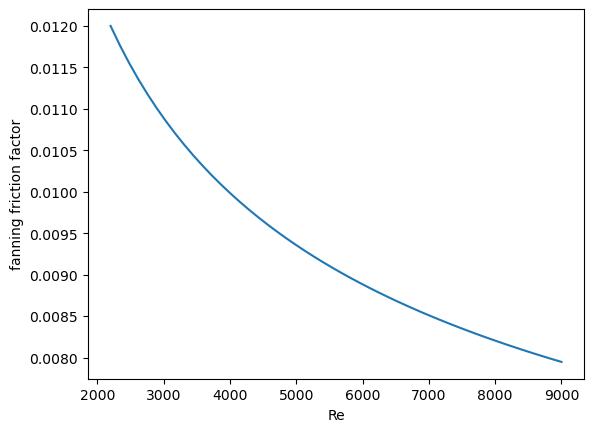

In [62]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

T = 25 + 273.15
Q = 2.5e-3  # m^3/s
deltaP = 103000  # Pa
deltaL = 100  # m

# Note these correlations expect dimensionless T, where the magnitude
# of T is in K


def rho(T):
    return 46.048 + 9.418 * T - 0.0329 * T**2 + 4.882e-5 * T**3 - 2.895e-8 * T**4


def mu(T):
    return np.exp(-10.547 + 541.69 / (T - 144.53))


def fanning_friction_factor_(Re):
    if Re < 2100:
        raise Exception("Flow is probably not turbulent, so this correlation is not appropriate.")

    # solve the Nikuradse correlation to get the friction factor
    def fz(f):
        return 1.0 / np.sqrt(f) - (4.0 * np.log10(Re * np.sqrt(f)) - 0.4)

    (sol,) = fsolve(fz, 0.01)
    return sol


fanning_friction_factor = np.vectorize(fanning_friction_factor_)

Re = np.linspace(2200, 9000)
f = fanning_friction_factor(Re)

plt.plot(Re, f)
plt.xlabel("Re")
plt.ylabel("fanning friction factor")
# You can see why we use 0.01 as an initial guess for solving for the
# Fanning friction factor; it falls in the middle of ranges possible
# for these Re numbers.


def objective(D):
    v = Q / (np.pi * D**2 / 4)
    Re = D * v * rho(T) / mu(T)

    fF = fanning_friction_factor(Re)

    return deltaP - 2 * fF * rho(T) * deltaL * v**2 / D


(D,) = fsolve(objective, 0.04)

print("The minimum pipe diameter is {0} m\n".format(D))

Any pipe diameter smaller than that value will result in a larger pressure drop at the same volumetric flow rate, or a smaller volumetric flowrate at the same pressure drop. Either way, it will not meet the design specification.



## Reading parameter database text files in python



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/10/reading-parameter-database-text-files-in-matlab/)

The datafile at [http://terpconnect.umd.edu/~nsw/ench250/antoine.dat>](http://terpconnect.umd.edu/~nsw/ench250/antoine.dat>)(dead link) contains data that can be used to estimate the vapor pressure of about 700 pure compounds using the Antoine equation

The data file has the following contents:

    Antoine Coefficients
      log(P) = A-B/(T+C) where P is in mmHg and T is in Celsius
    Source of data: Yaws and Yang (Yaws, C.  L.  and Yang, H.  C.,
    "To estimate vapor pressure easily. antoine coefficients relate vapor pressure to temperature for almost 700 major organic compounds", Hydrocarbon Processing, 68(10), p65-68, 1989.
    
    ID  formula  compound name                  A       B       C     Tmin Tmax ??    ?
    -----------------------------------------------------------------------------------
      1 CCL4     carbon-tetrachloride        6.89410 1219.580 227.170  -20  101 Y2    0
      2 CCL3F    trichlorofluoromethane      6.88430 1043.010 236.860  -33   27 Y2    0
      3 CCL2F2   dichlorodifluoromethane     6.68619  782.072 235.377 -119  -30 Y6    0

To use this data, you find the line that has the compound you want, and read off the data. You could do that manually for each component you want but that is tedious, and error prone. Today we will see how to retrieve the file, then read the data into python to create a database we can use to store and retrieve the data.

We will use the data to find the temperature at which the vapor pressure of acetone is 400 mmHg.

We use numpy.loadtxt to read the file, and tell the function the format of each column. This creates a special kind of record array which we can access data by field name.



In [71]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt(
    "../../data/antoine_data.dat",
    dtype=[
        ("id", int),
        ("formula", "S8"),
        ("name", "S28"),
        ("A", float),
        ("B", float),
        ("C", float),
        ("Tmin", float),
        ("Tmax", float),
        ("??", "S4"),
        ("?", "S4"),
    ],
    skiprows=7,
)

names = data["name"]

acetone = data[names == b"acetone"][0]
acetone

(107, b'C3H6O', b'acetone', 7.2316, 1277.03, 237.23, -32., 77., b'Y2', b'0')

38.61381981965211
The vapor pressure is 400 mmHg at T = 38.6 degC


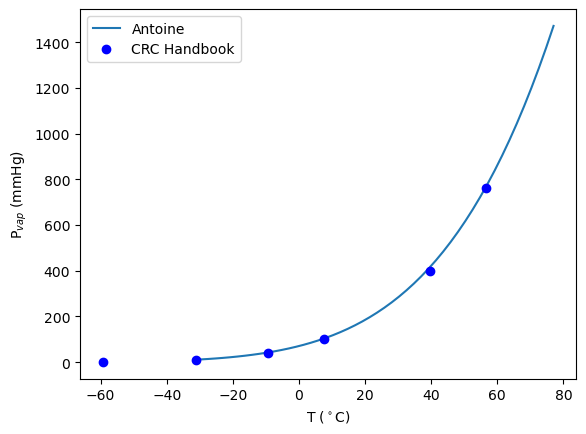

In [73]:
# for readability we unpack the array into variables
id, formula, name, A, B, C, Tmin, Tmax, u1, u2 = acetone

T = np.linspace(Tmin, Tmax)
P = 10 ** (A - B / (T + C))
plt.plot(T, P)
plt.xlabel("T ($^\circ$C)")
plt.ylabel("P$_{vap}$ (mmHg)")

# Find T at which Pvap = 400 mmHg
# from our graph we might guess T ~ 40 ^{\circ}C


def objective(T):
    return 400 - 10 ** (A - B / (T + C))


from scipy.optimize import fsolve

(Tsol,) = fsolve(objective, 40)
print(Tsol)
print("The vapor pressure is 400 mmHg at T = {0:1.1f} degC".format(Tsol))

# Plot CRC data http://en.wikipedia.org/wiki/Acetone_%28data_page%29#Vapor_pressure_of_liquid
# We only include the data for the range where the Antoine fit is valid.

Tcrc = [-59.4, -31.1, -9.4, 7.7, 39.5, 56.5]
Pcrc = [1, 10, 40, 100, 400, 760]

plt.plot(Tcrc, Pcrc, "bo")
plt.legend(["Antoine", "CRC Handbook"], loc="best");

This result is close to the value reported [ here](http://en.wikipedia.org/wiki/Acetone_%28data_page%29#Vapor_pressure_of_liquid) (39.5 degC), from the CRC Handbook. The difference is probably that the value reported in the CRC is an actual experimental number.



## Calculating a bubble point pressure of a mixture



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/15/calculating-a-bubble-point-pressure/)

Adapted from [http://terpconnect.umd.edu/~nsw/ench250/bubpnt.htm>](http://terpconnect.umd.edu/~nsw/ench250/bubpnt.htm>)(dead link)

We previously learned to read a datafile containing lots of Antoine coefficients into a database, and use the coefficients to estimate vapor pressure of a single compound. Here we use those coefficents to compute a bubble point pressure of a mixture.

The bubble point is the temperature at which the sum of the component vapor pressures is equal to the the total pressure. This is where a bubble of vapor will first start forming, and the mixture starts to boil.

Consider an equimolar mixture of benzene, toluene, chloroform, acetone and methanol. Compute the bubble point at 760 mmHg, and the gas phase composition. The gas phase composition is given by: $y_i = x_i*P_i/P_T$.



In [76]:
import numpy as np
from scipy.optimize import fsolve

# load our thermodynamic data
data = np.loadtxt(
    "../../data/antoine_data.dat",
    dtype=[
        ("id", int),
        ("formula", "S8"),
        ("name", "S28"),
        ("A", float),
        ("B", float),
        ("C", float),
        ("Tmin", float),
        ("Tmax", float),
        ("??", "S4"),
        ("?", "S4"),
    ],
    skiprows=7,
)

compounds = ["benzene", "toluene", "chloroform", "acetone", "methanol"]

# extract the data we want
A = np.array([data[data["name"] == x.encode(encoding="UTF-8")]["A"][0] for x in compounds])
B = np.array([data[data["name"] == x.encode(encoding="UTF-8")]["B"][0] for x in compounds])
C = np.array([data[data["name"] == x.encode(encoding="UTF-8")]["C"][0] for x in compounds])
Tmin = np.array([data[data["name"] == x.encode(encoding="UTF-8")]["Tmin"][0] for x in compounds])
Tmax = np.array([data[data["name"] == x.encode(encoding="UTF-8")]["Tmax"][0] for x in compounds])

# we have an equimolar mixture
x = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Given a T, we can compute the pressure of each species like this:

T = 67  # degC
P = 10 ** (A - B / (T + C))
print(P)
print(np.dot(x, P))  # total mole-fraction weighted pressure

Tguess = 67
Ptotal = 760


def func(T):
    P = 10 ** (A - B / (T + C))
    return Ptotal - np.dot(x, P)


(Tbubble,) = fsolve(func, Tguess)

print("The bubble point is {0:1.2f} degC".format(Tbubble))

# double check answer is in a valid T range
if np.any(Tbubble < Tmin) or np.any(Tbubble > Tmax):
    print("T_bubble is out of range!")

# print gas phase composition
y = x * 10 ** (A - B / (Tbubble + C)) / Ptotal

for cmpd, yi in zip(compounds, y):
    print("y_{0:<10s} = {1:1.3f}".format(cmpd, yi))

[ 498.4320267   182.16010994  898.31061294 1081.48181768  837.88860027]
699.654633507494
The bubble point is 69.46 degC
y_benzene    = 0.142
y_toluene    = 0.053
y_chloroform = 0.255
y_acetone    = 0.308
y_methanol   = 0.242


## The equal area method for the van der Waals equation



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/11/the-equal-area-method-for-the-van-der-waals-equation/)

When a gas is below its Tc the van der Waal equation oscillates. In the portion of the isotherm where $\partial P_R/\partial V_r > 0$, the isotherm fails to describe real materials, which phase separate into a liquid and gas in this region.

Maxwell proposed to replace this region by a flat line, where the area above and below the curves are equal. Today, we examine how to identify where that line should be.



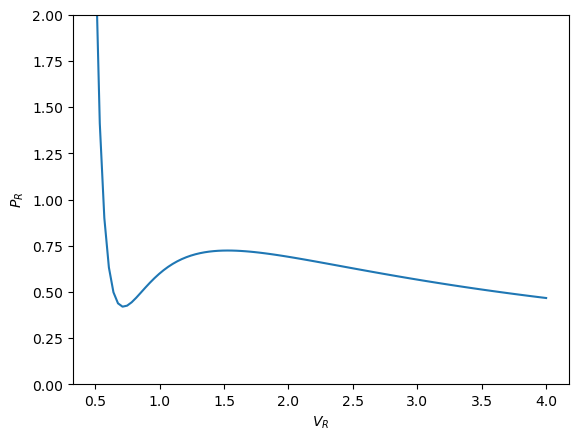

In [78]:
import numpy as np
import matplotlib.pyplot as plt

Tr = 0.9  # A Tr below Tc:  Tr = T/Tc


# analytical equation for Pr. This is the reduced form of the van der Waal
# equation.
def Prfh(Vr):
    return 8.0 / 3.0 * Tr / (Vr - 1.0 / 3.0) - 3.0 / (Vr**2)


Vr = np.linspace(0.5, 4, 100)  # vector of reduced volume
Pr = Prfh(Vr)  # vector of reduced pressure

plt.clf()
plt.plot(Vr, Pr)
plt.ylim([0, 2])
plt.xlabel("$V_R$")
plt.ylabel("$P_R$");

The idea is to pick a Pr and draw a line through the EOS. We want the areas between the line and EOS to be equal on each side of the middle intersection. Let us draw a line on the figure at y = 0.65.



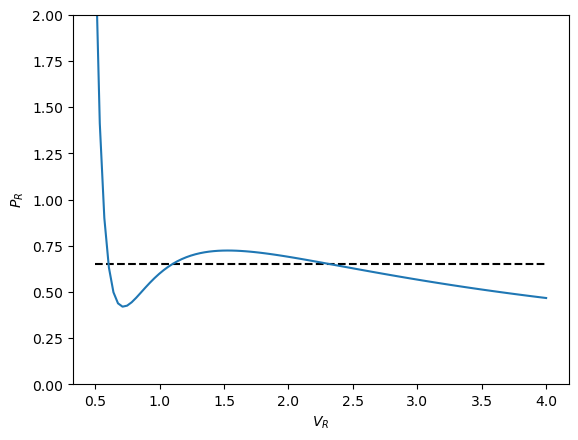

In [80]:
y = 0.65

plt.plot([0.5, 4.0], [y, y], "k--")
plt.plot(Vr, Pr)
plt.ylim([0, 2])
plt.xlabel("$V_R$")
plt.ylabel("$P_R$");

To find the areas, we need to know where the intersection of the vdW eqn with the horizontal line. This is the same as asking what are the roots of the vdW equation at that Pr. We need all three intersections so we can integrate from the first root to the middle root, and then the middle root to the third root. We take advantage of the polynomial nature of the vdW equation, which allows us to use the roots command to get all the roots at once. The polynomial is $V_R^3 - \frac{1}{3}(1+8 T_R/P_R) + 3/P_R - 1/P_R = 0$. We use the coefficients t0 get the roots like this.



[0.60286812 1.09743234 2.32534056]


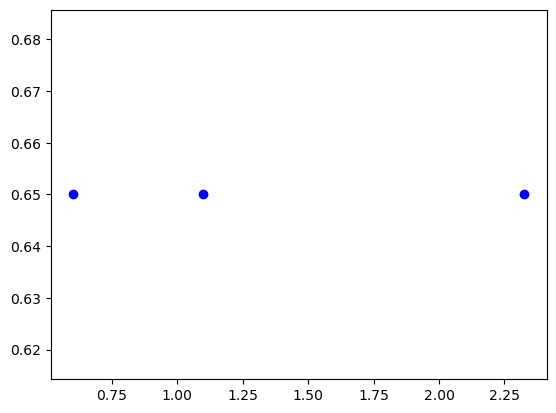

In [81]:
vdWp = [1.0, -1.0 / 3.0 * (1.0 + 8.0 * Tr / y), 3.0 / y, -1.0 / y]
v = np.roots(vdWp)
v.sort()
print(v)

plt.plot(v[0], y, "bo", v[1], y, "bo", v[2], y, "bo");

### Compute areas



for A1, we need the area under the line minus the area under the vdW curve. That is the area between the curves. For A2, we want the area under the vdW curve minus the area under the line. The area under the line between root 2 and root 1 is just the width (root2 - root1)\*y



In [82]:
from scipy.integrate import quad

A1, e1 = (v[1] - v[0]) * y - quad(Prfh, v[0], v[1])
A2, e2 = quad(Prfh, v[1], v[2]) - (v[2] - v[1]) * y

print(A1, A2)
print(e1, e2)  # interesting these look so large

0.06322594560601252 0.05802120981218639
0.3214667437645078 -0.7981403392675809


In [85]:
from scipy.optimize import fsolve


def equal_area(y):
    Tr = 0.9
    vdWp = [1, -1.0 / 3 * (1.0 + 8.0 * Tr / y), 3.0 / y, -1.0 / y]
    v = np.roots(vdWp)
    v.sort()
    A1 = (v[1] - v[0]) * y - quad(Prfh, v[0], v[1])[0]
    A2 = quad(Prfh, v[1], v[2])[0] - (v[2] - v[1]) * y
    return A1 - A2


(y_eq,) = fsolve(equal_area, 0.65)
print(y_eq)

Tr = 0.9
vdWp = [1, -1.0 / 3 * (1.0 + 8.0 * Tr / y_eq), 3.0 / y_eq, -1.0 / y_eq]
v = np.roots(vdWp)
v.sort()

A1, e1 = (v[1] - v[0]) * y_eq - quad(Prfh, v[0], v[1])
A2, e2 = quad(Prfh, v[1], v[2]) - (v[2] - v[1]) * y_eq

print(A1, A2)

0.6469983518722509
0.06175264739937192 0.06175264739937192


Now let us plot the equal areas and indicate them by shading.



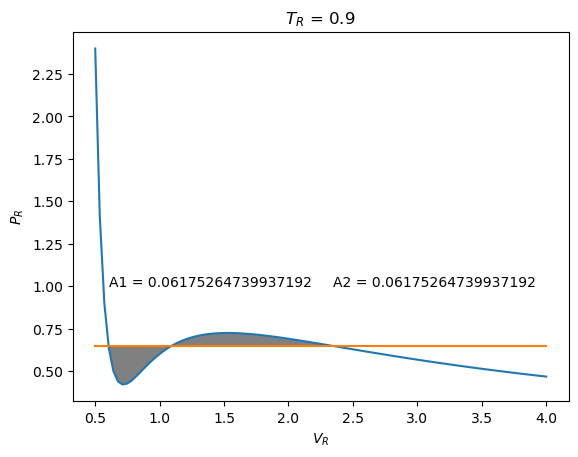

In [86]:
fig = plt.gcf()
ax = fig.add_subplot(111)

ax.plot(Vr, Pr)

hline = np.ones(Vr.size) * y_eq

ax.plot(Vr, hline)
ax.fill_between(Vr, hline, Pr, where=(Vr >= v[0]) & (Vr <= v[1]), facecolor="gray")
ax.fill_between(Vr, hline, Pr, where=(Vr >= v[1]) & (Vr <= v[2]), facecolor="gray")

plt.text(v[0], 1, "A1 = {0}".format(A1))
plt.text(v[2], 1, "A2 = {0}".format(A2))
plt.xlabel("$V_R$")
plt.ylabel("$P_R$")
plt.title("$T_R$ = 0.9");

## Time dependent concentration in a first order reversible reaction in a batch reactor



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/07/first-order-reversible-reaction-in-batch-reactor/)

Given this reaction $A \rightleftharpoons B$, with these rate laws:

forward rate law: $-r_a = k_1 C_A$

backward rate law: $-r_b = k_{-1} C_B$

plot the concentration of A vs. time. This example illustrates a set of coupled first order ODES.



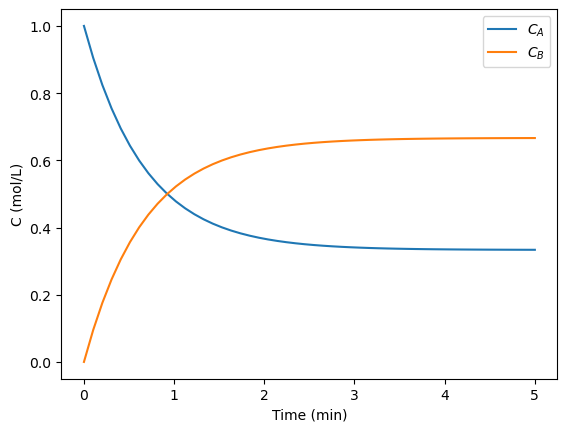

In [87]:
from scipy.integrate import odeint
import numpy as np


def myode(C, t):
    # ra = -k1*Ca
    # rb = -k_1*Cb
    # net rate for production of A:  ra - rb
    # net rate for production of B: -ra + rb

    k1 = 1  # 1/min;
    k_1 = 0.5  # 1/min;

    Ca = C[0]
    Cb = C[1]

    ra = -k1 * Ca
    rb = -k_1 * Cb

    dCadt = ra - rb
    dCbdt = -ra + rb

    dCdt = [dCadt, dCbdt]
    return dCdt


tspan = np.linspace(0, 5)

init = [1, 0]  # mol/L
C = odeint(myode, init, tspan)

Ca = C[:, 0]
Cb = C[:, 1]

import matplotlib.pyplot as plt

plt.plot(tspan, Ca, tspan, Cb)
plt.xlabel("Time (min)")
plt.ylabel("C (mol/L)")
plt.legend(["$C_A$", "$C_B$"]);

That is it. The main difference between this and Matlab is the order of arguments in odeint is different, and the ode function has differently ordered arguments.



## Finding equilibrium conversion



A common problem to solve in reaction engineering is finding the equilibrium conversion. A typical problem to solve is the following nonlinear equation:

$1.44 = \frac{X_e^2}{(1-X_e)^2}$

To solve this we create a function:

$f(X_e)=0=1.44 - \frac{X_e^2}{(1-X_e)^2}$

and use a nonlinear solver to find the value of $X_e$ that makes this function equal to zero. We have to provide an initial guess. Chemical intuition suggests that the solution must be between 0 and 1, and mathematical intuition suggests the solution might be near 0.5 (which would give a ratio near 1).

Here is our solution.



In [88]:
from scipy.optimize import fsolve


def func(Xe):
    z = 1.44 - (Xe**2) / (1 - Xe) ** 2
    return z


X0 = 0.5
(Xe,) = fsolve(func, X0)
print("The equilibrium conversion is X = {0:1.2f}".format(Xe))

The equilibrium conversion is X = 0.55


See Fogler, 4th ed. page 1025 for the setup of this equation.



## Integrating a batch reactor design equation



For a constant volume batch reactor where $A \rightarrow B$ at a rate of $-r_A = k C_A^2$, we derive the following design equation for the length of time required to achieve a particular level of conversion :

$t(X) = \frac{1}{k C_{A0}} \int_{X=0}^X \frac{dX}{(1-X)^2}$

if $k = 10^{-3}$ L/mol/s and $C_{A0}$ = 1 mol/L, estimate the time to achieve 90% conversion.

We could analytically solve the integral and evaluate it, but instead we will numerically evaluate it using scipy.integrate.quad. This function returns two values: the evaluated integral, and an estimate of the absolute error in the answer.



In [89]:
from scipy.integrate import quad


def integrand(X):
    k = 1.0e-3
    Ca0 = 1.0  # mol/L
    return 1.0 / (k * Ca0) * (1.0 / (1 - X) ** 2)


sol, abserr = quad(integrand, 0, 0.9)
print("t = {0} seconds ({1} hours)".format(sol, sol / 3600))
print("Estimated absolute error = {0}".format(abserr))

t = 9000.000000000007 seconds (2.500000000000002 hours)
Estimated absolute error = 2.1220327407235617e-07


You can see the estimate error is very small compared to the solution.



## Uncertainty in an integral equation



In a [previous example](http://jkitchin.github.io/blog/2013/01/06/Integrating-a-batch-reactor-design-equation/), we solved for the time to reach a specific conversion in a batch reactor. However, it is likely there is uncertainty in the rate constant, and possibly in the initial concentration. Here we examine the effects of that uncertainty on the time to reach the desired conversion.

To do this we have to write a function that takes arguments with uncertainty, and wrap the function with the uncertainties.wrap decorator. The function must return a single float number (current limitation of the uncertainties package). Then, we simply call the function, and the uncertainties from the inputs will be automatically propagated to the outputs. Let us say there is about 10% uncertainty in the rate constant, and 1% uncertainty in the initial concentration.



In [90]:
from scipy.integrate import quad
import uncertainties as u

k = u.ufloat(1.0e-3, 1.0e-4)
Ca0 = u.ufloat(1.0, 0.01)  # mol/L


@u.wrap
def func(k, Ca0):
    def integrand(X):
        return 1.0 / (k * Ca0) * (1.0 / (1 - X) ** 2)

    integral, abserr = quad(integrand, 0, 0.9)
    return integral


sol = func(k, Ca0)
print("t = {0} seconds ({1} hours)".format(sol, sol / 3600))

t = (9.0+/-0.9)e+03 seconds (2.50+/-0.25 hours)


The result shows about a 10% uncertainty in the time, which is similar to the largest uncertainty in the inputs.  This information should certainly be used in making decisions about how long to actually run the reactor to be sure of reaching the goal. For example, in this case, running the reactor for 3 hours (that is roughly + 2&sigma;) would ensure at a high level of confidence (approximately 95% confidence) that you reach at least 90% conversion.



## Integrating the batch reactor mole balance



An alternative approach of evaluating an integral is to integrate a differential equation. For the batch reactor, the differential equation that describes conversion as a function of time is:

$\frac{dX}{dt} = -r_A V/N_{A0}$.

Given a value of initial concentration, or volume and initial number of moles of A, we can integrate this ODE to find the conversion at some later time. We assume that $X(t=0)=0$. We will integrate the ODE over a time span of 0 to 10,000 seconds.



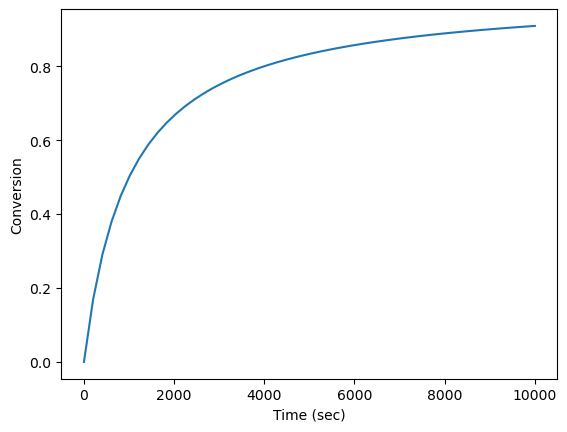

In [91]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

k = 1.0e-3
Ca0 = 1.0  # mol/L


def func(X, t):
    ra = -k * (Ca0 * (1 - X)) ** 2
    return -ra / Ca0


X0 = 0
tspan = np.linspace(0, 10000)

sol = odeint(func, X0, tspan)
plt.plot(tspan, sol)
plt.xlabel("Time (sec)")
plt.ylabel("Conversion");

You can read off of this figure to find the time required to achieve a particular conversion.



## Plug flow reactor with a pressure drop



If there is a pressure drop in a plug flow reactor,  there are two equations needed to determine the exit conversion: one for the conversion, and one from the pressure drop.

\begin{eqnarray}
\frac{dX}{dW} &=& \frac{k'}{F_A0} \left ( \frac{1-X}{1 + \epsilon X} \right) y\\
\frac{dX}{dy} &=& -\frac{\alpha (1 + \epsilon X)}{2y}
\end{eqnarray}

Here is how to integrate these equations numerically in python.



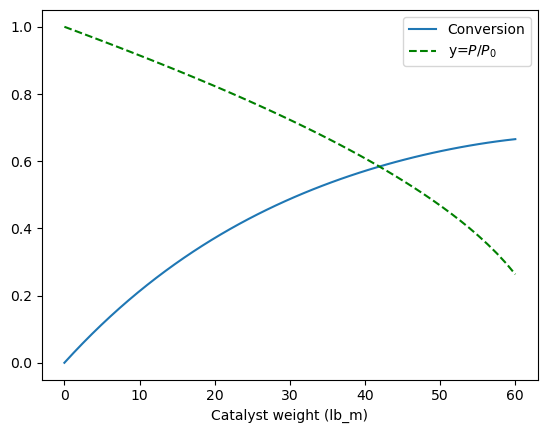

In [92]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

kprime = 0.0266
Fa0 = 1.08
alpha = 0.0166
epsilon = -0.15


def dFdW(F, W):
    "set of ODEs to integrate"
    X = F[0]
    y = F[1]
    dXdW = kprime / Fa0 * (1 - X) / (1 + epsilon * X) * y
    dydW = -alpha * (1 + epsilon * X) / (2 * y)
    return [dXdW, dydW]


Wspan = np.linspace(0, 60)
X0 = 0.0
y0 = 1.0
F0 = [X0, y0]
sol = odeint(dFdW, F0, Wspan)

# now plot the results
plt.plot(Wspan, sol[:, 0], label="Conversion")
plt.plot(Wspan, sol[:, 1], "g--", label="y=$P/P_0$")
plt.legend(loc="best")
plt.xlabel("Catalyst weight (lb_m)");

See Fogler, 4th edition. page 193.



## Solving CSTR design equations



Given a continuously stirred tank reactor with a volume of 66,000 dm^3 where the reaction $A \rightarrow B$ occurs, at a rate of $-r_A = k C_A^2$ ($k=3$ L/mol/h), with an entering molar flow of F<sub>A0</sub> = 5 mol/h and a volumetric flowrate of 10 L/h, what is the exit concentration of A?

From a mole balance we know that at steady state $0 = F_{A0} - F_A + V r_A$. That equation simply states the sum of the molar flow of A in in minus the molar flow of A out  plus the molar rate A is generated is equal to zero at steady state. This is directly the equation we need to solve. We need the following relationship:

1.  $F_A = v0 C_A$



In [93]:
from scipy.optimize import fsolve

Fa0 = 5.0
v0 = 10.0

V = 66000.0  # reactor volume L^3
k = 3.0  # rate constant L/mol/h


def func(Ca):
    "Mole balance for a CSTR. Solve this equation for func(Ca)=0"
    Fa = v0 * Ca  # exit molar flow of A
    ra = -k * Ca**2  # rate of reaction of A L/mol/h
    return Fa0 - Fa + V * ra


# CA guess that that 90 % is reacted away
CA_guess = 0.1 * Fa0 / v0
(CA_sol,) = fsolve(func, CA_guess)

print("The exit concentration is {0} mol/L".format(CA_sol))

The exit concentration is 0.005 mol/L


It is a little confusing why it is necessary to put a comma after the CA\_sol in the fsolve command. If you do not put it there, you get brackets around the answer.



## Meet the steam tables



[Matlab post](http://matlab.cheme.cmu.edu/2011/10/31/matlab-meets-the-steam-tables/)

We will use the [iapws](https://pypi.python.org/pypi/iapws) module. Install it like this:

    pip install iapws

Problem statement: A Rankine cycle operates using steam with the condenser at 100 degC, a pressure of 3.0 MPa and temperature of 600 degC in the boiler. Assuming the compressor and turbine operate reversibly, estimate the efficiency of the cycle.

Starting point in the Rankine cycle in condenser.

we have saturated liquid here, and we get the thermodynamic properties for the given temperature. In this python module, these properties are all in attributes of an IAPWS object created at a set of conditions.



### Starting point in the Rankine cycle in condenser.



We have saturated liquid here, and we get the thermodynamic properties for the given temperature.



In [96]:
from iapws import IAPWS97

T1 = 100 + 273.15  # in K

sat_liquid1 = IAPWS97(T=T1, x=0)  # x is the steam quality. 0 = liquid

P1 = sat_liquid1.P
s1 = sat_liquid1.s
h1 = sat_liquid1.h
v1 = sat_liquid1.v

### Isentropic compression of liquid to point 2



The final pressure is given, and we need to compute the new temperatures, and enthalpy.



In [97]:
P2 = 3.0  # MPa
s2 = s1  # this is what isentropic means

sat_liquid2 = IAPWS97(P=P2, s=s1)
T2 = sat_liquid2.T
h2 = sat_liquid2.h

# work done to compress liquid. This is an approximation, since the
# volume does change a little with pressure, but the overall work here
# is pretty small so we neglect the volume change.
WdotP = v1 * (P2 - P1)
print("The compressor work is: {0:1.4f} kJ/kg".format(WdotP))

The compressor work is: 0.0030 kJ/kg


The compression work is almost negligible. This number is 1000 times smaller than we computed with Xsteam. I wonder what the units of v1 actually are.



### Isobaric heating to T3 in boiler where we make steam



In [98]:
T3 = 600 + 273.15  # K
P3 = P2  # definition of isobaric
steam = IAPWS97(P=P3, T=T3)

h3 = steam.h
s3 = steam.s

Qb = h3 - h2  # heat required to make the steam

print("The boiler heat duty is: {0:1.2f} kJ/kg".format(Qb))

The boiler heat duty is: 3260.69 kJ/kg


### Isentropic expansion through turbine to point 4



In [99]:
steam = IAPWS97(P=P1, s=s3)
T4 = steam.T
h4 = steam.h
s4 = s3  # isentropic
Qc = h4 - h1  # work required to cool from T4 to T1

print("The condenser heat duty is {0:1.2f} kJ/kg".format(Qc))

The condenser heat duty is 2317.00 kJ/kg


### To get from point 4 to point 1



In [100]:
WdotTurbine = h4 - h3  # work extracted from the expansion
print("The turbine work is: {0:1.2f} kJ/kg".format(WdotTurbine))

The turbine work is: -946.71 kJ/kg


### Efficiency



This is a ratio of the work put in to make the steam, and the net work obtained from the turbine. The answer here agrees with the efficiency calculated in Sandler on page 135.



In [101]:
eta = -(WdotTurbine - WdotP) / Qb
print("The overall efficiency is {0:1.2%}.".format(eta))

The overall efficiency is 29.03%.


### Entropy-temperature chart



The IAPWS module makes it pretty easy to generate figures of the steam tables. Here we generate an entropy-Temperature graph. We do this to illustrate the path of the Rankine cycle. We need to compute the values of steam entropy for a range of pressures and temperatures.



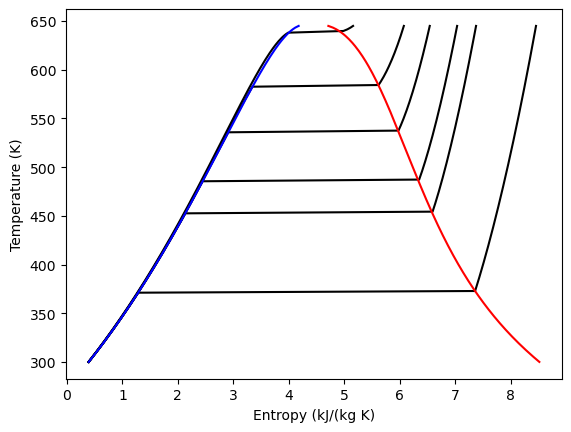

In [102]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.clf()
T = np.linspace(300, 372 + 273, 200)  # range of temperatures
for P in [0.1, 1, 2, 5, 10, 20]:  # MPa
    steam = [IAPWS97(T=t, P=P) for t in T]
    S = [s.s for s in steam]
    plt.plot(S, T, "k-")

# saturated vapor and liquid entropy lines
svap = [s.s for s in [IAPWS97(T=t, x=1) for t in T]]
sliq = [s.s for s in [IAPWS97(T=t, x=0) for t in T]]

plt.plot(svap, T, "r-")
plt.plot(sliq, T, "b-")

plt.xlabel("Entropy (kJ/(kg K)")
plt.ylabel("Temperature (K)");

We can plot our Rankine cycle path like this. We compute the entropies along the non-isentropic paths.



In [103]:
T23 = np.linspace(T2, T3)
S23 = [s.s for s in [IAPWS97(P=P2, T=t) for t in T23]]

T41 = np.linspace(T4, T1 - 0.01)  # subtract a tiny bit to make sure we get a liquid
S41 = [s.s for s in [IAPWS97(P=P1, T=t) for t in T41]]

And then we plot the paths.



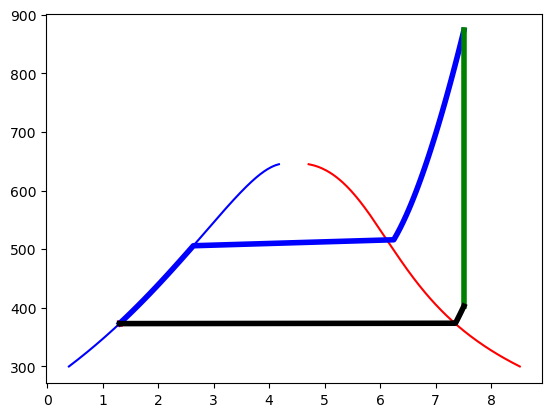

In [104]:
plt.plot(svap, T, "r-")
plt.plot(sliq, T, "b-")


plt.plot([s1, s2], [T1, T2], "r-", lw=4)  # Path 1 to 2
plt.plot(S23, T23, "b-", lw=4)  # path from 2 to 3 is isobaric
plt.plot([s3, s4], [T3, T4], "g-", lw=4)  # path from 3 to 4 is isentropic
plt.plot(S41, T41, "k-", lw=4);  # and from 4 to 1 is isobaric

### Summary



This was an interesting exercise. On one hand, the tedium of interpolating the steam tables is gone. On the other hand, you still have to know exactly what to ask for to get an answer that is correct. The iapws interface is a little clunky, and takes some getting used to. It does not seem as robust as the Xsteam module I used in Matlab.



## What region is a point in



Suppose we have a space that is divided by a boundary into two regions, and we want to know if an arbitrary point is on one region or the other. One way to figure this out is to pick a point that is known to be in a region, and then draw a line to the arbitrary point counting the number of times it crosses the boundary. If the line crosses an even number of times, then the point is in the same region and if it crosses an odd number of times, then the point is in the other region.

Here is the boundary and region we consider in this example:



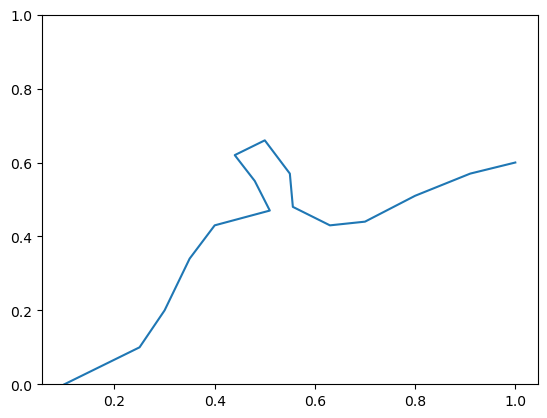

In [105]:
boundary = [
    [0.1, 0],
    [0.25, 0.1],
    [0.3, 0.2],
    [0.35, 0.34],
    [0.4, 0.43],
    [0.51, 0.47],
    [0.48, 0.55],
    [0.44, 0.62],
    [0.5, 0.66],
    [0.55, 0.57],
    [0.556, 0.48],
    [0.63, 0.43],
    [0.70, 0.44],
    [0.8, 0.51],
    [0.91, 0.57],
    [1.0, 0.6],
]

import matplotlib.pyplot as plt

plt.clf()
plt.plot([p[0] for p in boundary], [p[1] for p in boundary])
plt.ylim([0, 1]);

In this example, the boundary is complicated, and not described by a simple function. We will check for intersections of the line from the arbitrary point to the reference point with each segment defining the boundary. If there is an intersection in the boundary, we count that as a crossing. We choose the origin (0, 0) in this case for the reference point. For an arbitrary point (x1, y1), the equation of the line is therefore (provided x1 !=0):

$y = \frac{y1}{x1} x$.

Let the points defining a boundary segment be (bx1, by1) and (bx2, by2). The equation for the line connecting these points (provided bx1 != bx2) is:

$y = by1 + \frac{by2 - by1}{bx2 - bx1}(x - bx1)$

Setting these two equations equal to each other, we can solve for the value of $x$, and if $bx1 <= x <= bx2$ then we would say there is an intersection with that segment. The solution for x is:

$x = \frac{m bx1 - by1}{m - y1/x1}$

This can only fail if $m = y1/x1$ which means the segments are parallel and either do not intersect or go through each other. One issue we have to resolve is what to do when the intersection is at the boundary. In that case, we would see an intersection with two segments since bx1 of one segment is also bx2 of another segment. We resolve the issue by only counting intersections with bx1. Finally, there may be intersections at values of $x$ greater than the point, and we are not interested in those because the intersections are not between the point and reference point.

We will have to do float comparisons, so we will define [tolerance functions](./math.md) for all of these. I tried this previously with regular comparison operators, and there were many cases that did not work because of float comparisons. In the code that follows, we define the tolerance functions, the function that handles almost all the special cases, and show that it almost always correctly identifies the region a point is in.



/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/339476128.py:64: RuntimeWarning: invalid value encountered in double_scalars
  m1 = y1 / x1
/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_19543/339476128.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  m1 = y1 / x1


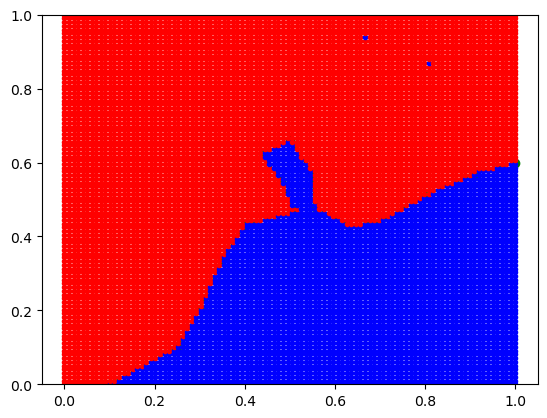

In [106]:
import numpy as np

TOLERANCE = 2 * np.spacing(1)


def feq(x, y, epsilon=TOLERANCE):
    "x == y"
    return not ((x < (y - epsilon)) or (y < (x - epsilon)))


def flt(x, y, epsilon=TOLERANCE):
    "x < y"
    return x < (y - epsilon)


def fgt(x, y, epsilon=TOLERANCE):
    "x > y"
    return y < (x - epsilon)


def fle(x, y, epsilon=TOLERANCE):
    "x <= y"
    return not (y < (x - epsilon))


def fge(x, y, epsilon=TOLERANCE):
    "x >= y"
    return not (x < (y - epsilon))


boundary = [
    [0.1, 0],
    [0.25, 0.1],
    [0.3, 0.2],
    [0.35, 0.34],
    [0.4, 0.43],
    [0.51, 0.47],
    [0.48, 0.55],
    [0.44, 0.62],
    [0.5, 0.66],
    [0.55, 0.57],
    [0.556, 0.48],
    [0.63, 0.43],
    [0.70, 0.44],
    [0.8, 0.51],
    [0.91, 0.57],
    [1.0, 0.6],
]


def intersects(p, isegment):
    "p is a point (x1, y1), isegment is an integer indicating which segment starting with 0"
    x1, y1 = p
    bx1, by1 = boundary[isegment]
    bx2, by2 = boundary[isegment + 1]
    if feq(bx1, bx2) and feq(x1, 0.0):  # both segments are vertical
        if feq(bx1, x1):
            return True
        else:
            return False
    elif feq(bx1, bx2):  # segment is vertical
        m1 = y1 / x1  # slope of reference line
        y = m1 * bx1  # value of reference line at bx1
        if (fge(y, by1) and flt(y, by2)) or (fle(y, by1) and fgt(y, by2)):
            # reference line intersects the segment
            return True
        else:
            return False
    else:  # neither reference line nor segment is vertical
        m = (by2 - by1) / (bx2 - bx1)  # segment slope
        m1 = y1 / x1
        if feq(m, m1):  # line and segment are parallel
            if feq(y1, m * bx1):
                return True
            else:
                return False
        else:  # lines are not parallel
            x = (m * bx1 - by1) / (m - m1)  # x at intersection
            if ((fge(x, bx1) and flt(x, bx2)) or (fle(x, bx1) and fgt(x, bx2))) and fle(x, x1):
                return True
            else:
                return False
    raise Exception("you should not get here")


import matplotlib.pyplot as plt

plt.plot([p[0] for p in boundary], [p[1] for p in boundary], "go-")
plt.ylim([0, 1])

N = 100

X = np.linspace(0, 1, N)

for x in X:
    for y in X:
        p = (x, y)
        nintersections = sum([intersects(p, i) for i in range(len(boundary) - 1)])
        if nintersections % 2 == 0:
            plt.plot(x, y, "r.")
        else:
            plt.plot(x, y, "b.")

If you look carefully, there are two blue points in the red region, which means there is some edge case we do not capture in our function. Kudos to the person who figures it out.
Update: It was pointed out that the points intersect a point on the line.

Today I would use a package like [Shapely](https://pypi.org/project/shapely/) for this.